In [48]:
from SVM_Test import noise_PCA_spectra, plot_PCA_noise, plot_PCA_acc
from SVM_Test import cross_fold_validation, chemical_shifts, plot_chemical_shift
from SVM_Test import add_gaus_shot_noise, plot_gaus_pois_noise, plot_conf_matrix, test_svm_cv, test_svm
from SVM_Train import plot_randomly_spectra, train_and_test_svm_model, optimize_SVM_clasifiers, plot_gridsearch_results
from SVM_Preprocessing import load_spectrum_image, kmeans_clustering, preprocesing_spectrum_image
from SVM_Preprocessing import plot_clustering, renorm, apply_mask, crop_spectra 

import os
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.externals import joblib

# Loading spectral datasets

In [3]:
os.chdir(r"Data")

In [4]:
labels,labels_raw = [],[]

Fe_All = (pd.read_pickle('Fe_All.pkl')) #Set1
labels = (pd.read_pickle('Fe_labels.pkl'))

Fe_raw = (pd.read_pickle('Fe_rw.pkl')) #Set2
labels_raw = (pd.read_pickle('Fe_rw_labels.pkl'))

Fe_All = np.array(Fe_All)
Fe_raw = np.array(Fe_raw)

print(Fe_All.shape,len(labels),Fe_raw.shape,len(labels_raw))

labels_MF,labels_MFrw = [],[]

MF = (pd.read_pickle('Fe_Mn.pkl')) #Set3
labels_MF = (pd.read_pickle('Fe_Mn_labels.pkl'))

MF_rw = (pd.read_pickle('Ferw_Mn.pkl')) #Set4
labels_MFrw = (pd.read_pickle('Ferw_Mn_labels.pkl'))

print(MF.shape,len(labels_MF),MF_rw.shape,len(labels_MFrw))

(2170, 400) 2170 (2170, 400) 2170
(5328, 400) 5328 (5328, 400) 5328


In [5]:
#Crop the spectral datasets: 
Fe_All_c = crop_spectra(Fe_All,49,349)
Fe_rw_c = crop_spectra(Fe_raw,49,349)
MF_c = crop_spectra(MF,49,349)
MF_rw_c = crop_spectra(MF_rw,49,349)

print(Fe_All_c.shape,len(labels),Fe_rw_c.shape,len(labels_raw))
print(MF_c.shape,len(labels_MF),MF_rw_c.shape,len(labels_MFrw))

(2170, 300) 2170 (2170, 300) 2170
(5328, 300) 5328 (5328, 300) 5328


In [6]:
#Build the set with the iron oxide digitazed spectra: 
wusti_dig = pd.read_pickle('dig_wustite.pkl')
magne_dig = pd.read_pickle('dig_magnetite.pkl')

fe_dig = np.concatenate((wusti_dig,magne_dig),axis=0)
fe_dig = np.array(fe_dig)

labels_digfe = []
for i in range(0,len(wusti_dig)):
    labels_digfe.append(0)
for i in range(0,len(magne_dig)):
    labels_digfe.append(1)

# Preprocessing an spectrum image: 

In [7]:
spec = load_spectrum_image("EELS Spectrum Image (dark ref corrected).dm3")
labels_A,centroids = kmeans_clustering(spec,3,pca=True,n_comp=7)

PCA applied.


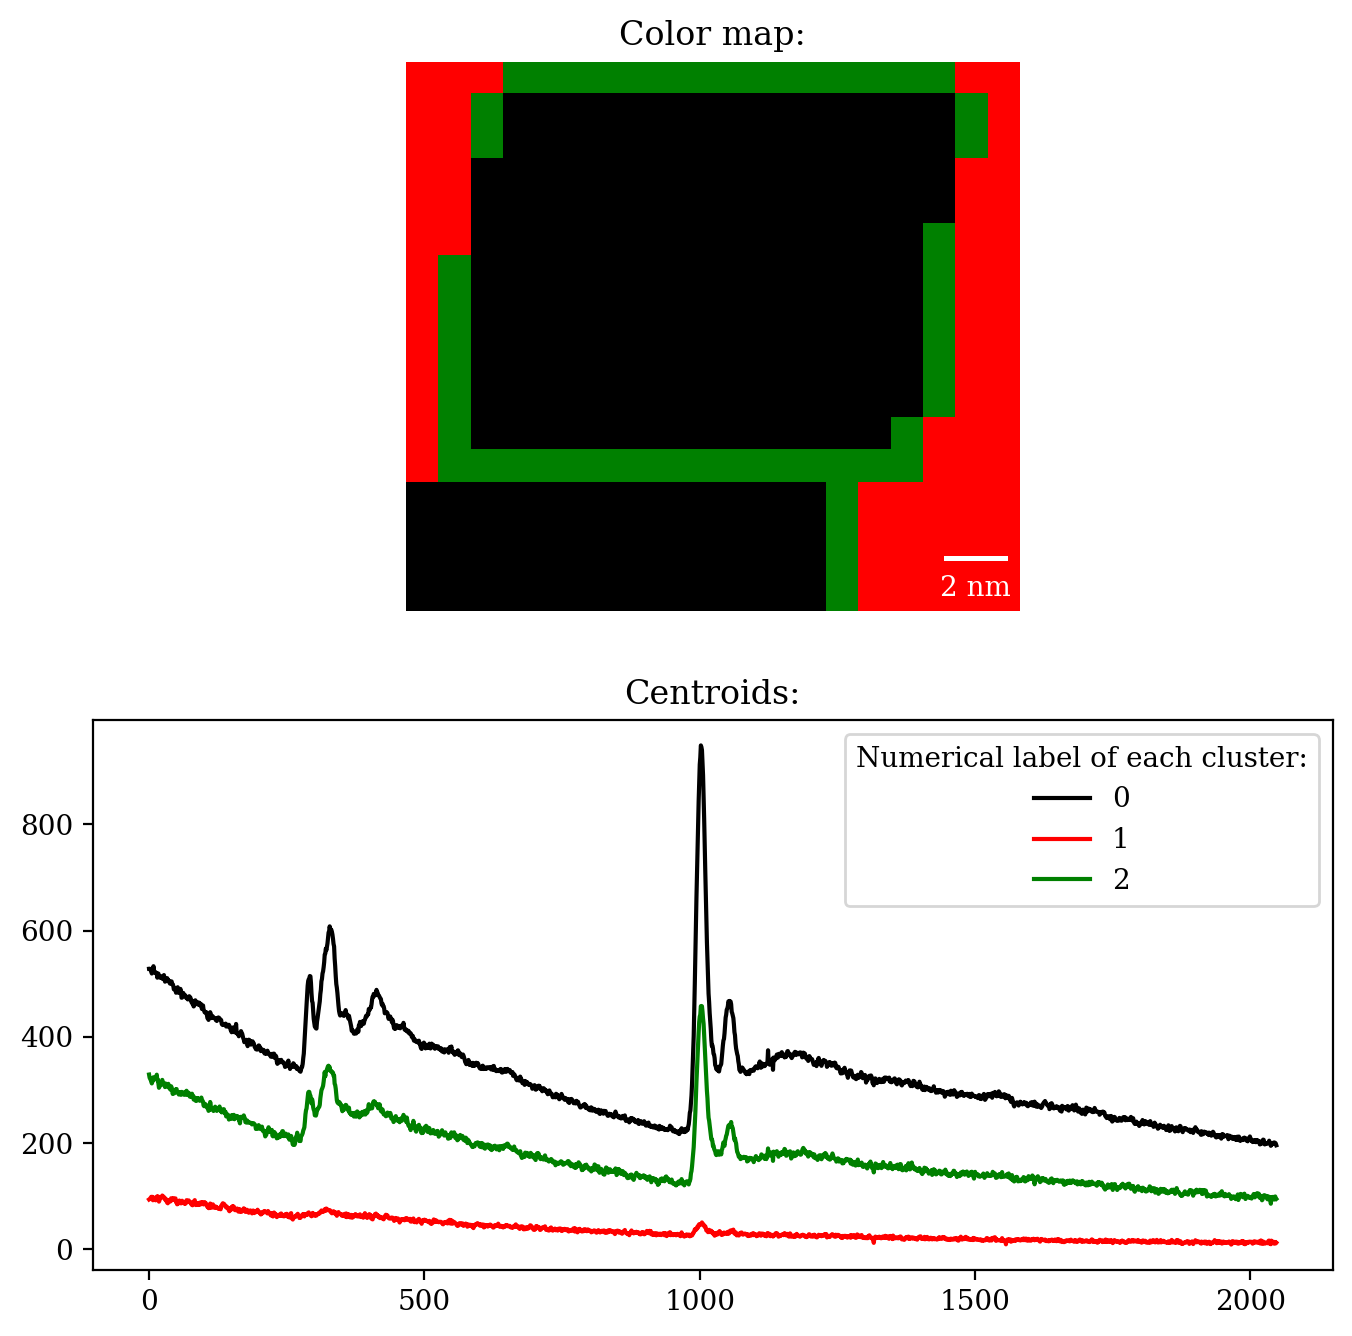

Figure not saved.


In [8]:
cm = mpl.colors.ListedColormap(['black','red','green'])
plot_clustering(labels_A,centroids,cm,pix_size=1e-9,fig_save=None)

In [9]:
spectra_pre = preprocesing_spectrum_image(spec,labels_A,0,670.,750.,670.,690.,pca=False,n_comp=8)

Model1D: 10 EELS Spectrum Image (dark ref corrected)
current_component_values: PowerLaw
Active: True
Parameter Name |  Free |      Value |        Std |        Min |        Max
============== | ===== | ========== | ========== | ========== | ==========
             A |  True | 0.01232242 |        nan |        0.0 |       None
   left_cutoff | False |        0.0 |       None |       None |       None
        origin | False |        0.0 |       None |       None |       None
             r |  True | -1.3569122 |        nan |        1.0 |        5.0

(800,) (320,) (207, 320)


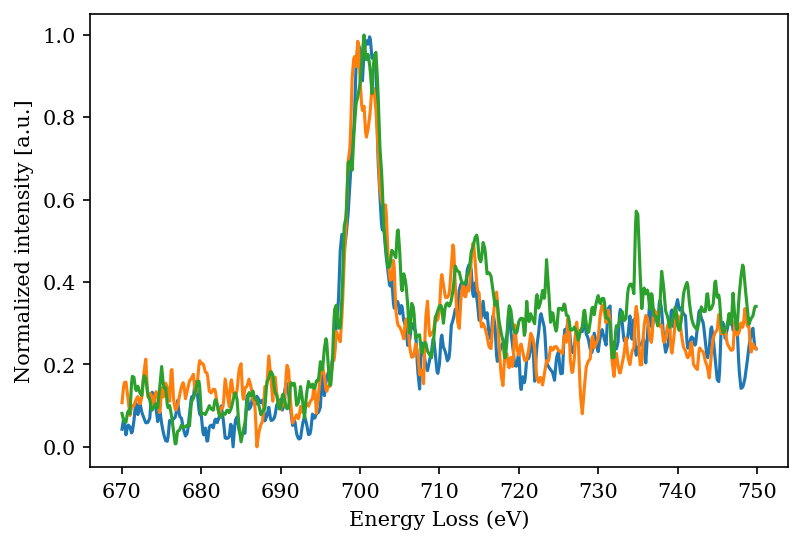

In [15]:
#Some spectra plotted: 
plt.figure(dpi=150)
plt.xlabel('Energy Loss (eV)')
plt.ylabel('Normalized intensity [a.u.]')
plt.plot(np.arange(670,750,step=.1),spectra_pre[100])
plt.plot(np.arange(670,750,step=.1),spectra_pre[200])
plt.plot(np.arange(670,750,step=.1),spectra_pre[150])

In [16]:
masked_spec = apply_mask(spec,labels_A,1)

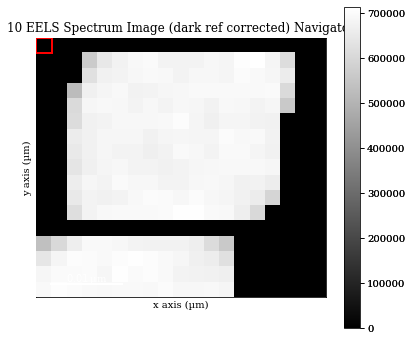

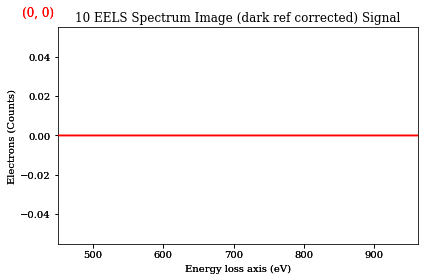

In [17]:
masked_spec.plot()

# SVM analysis:

## Plot random spectra:

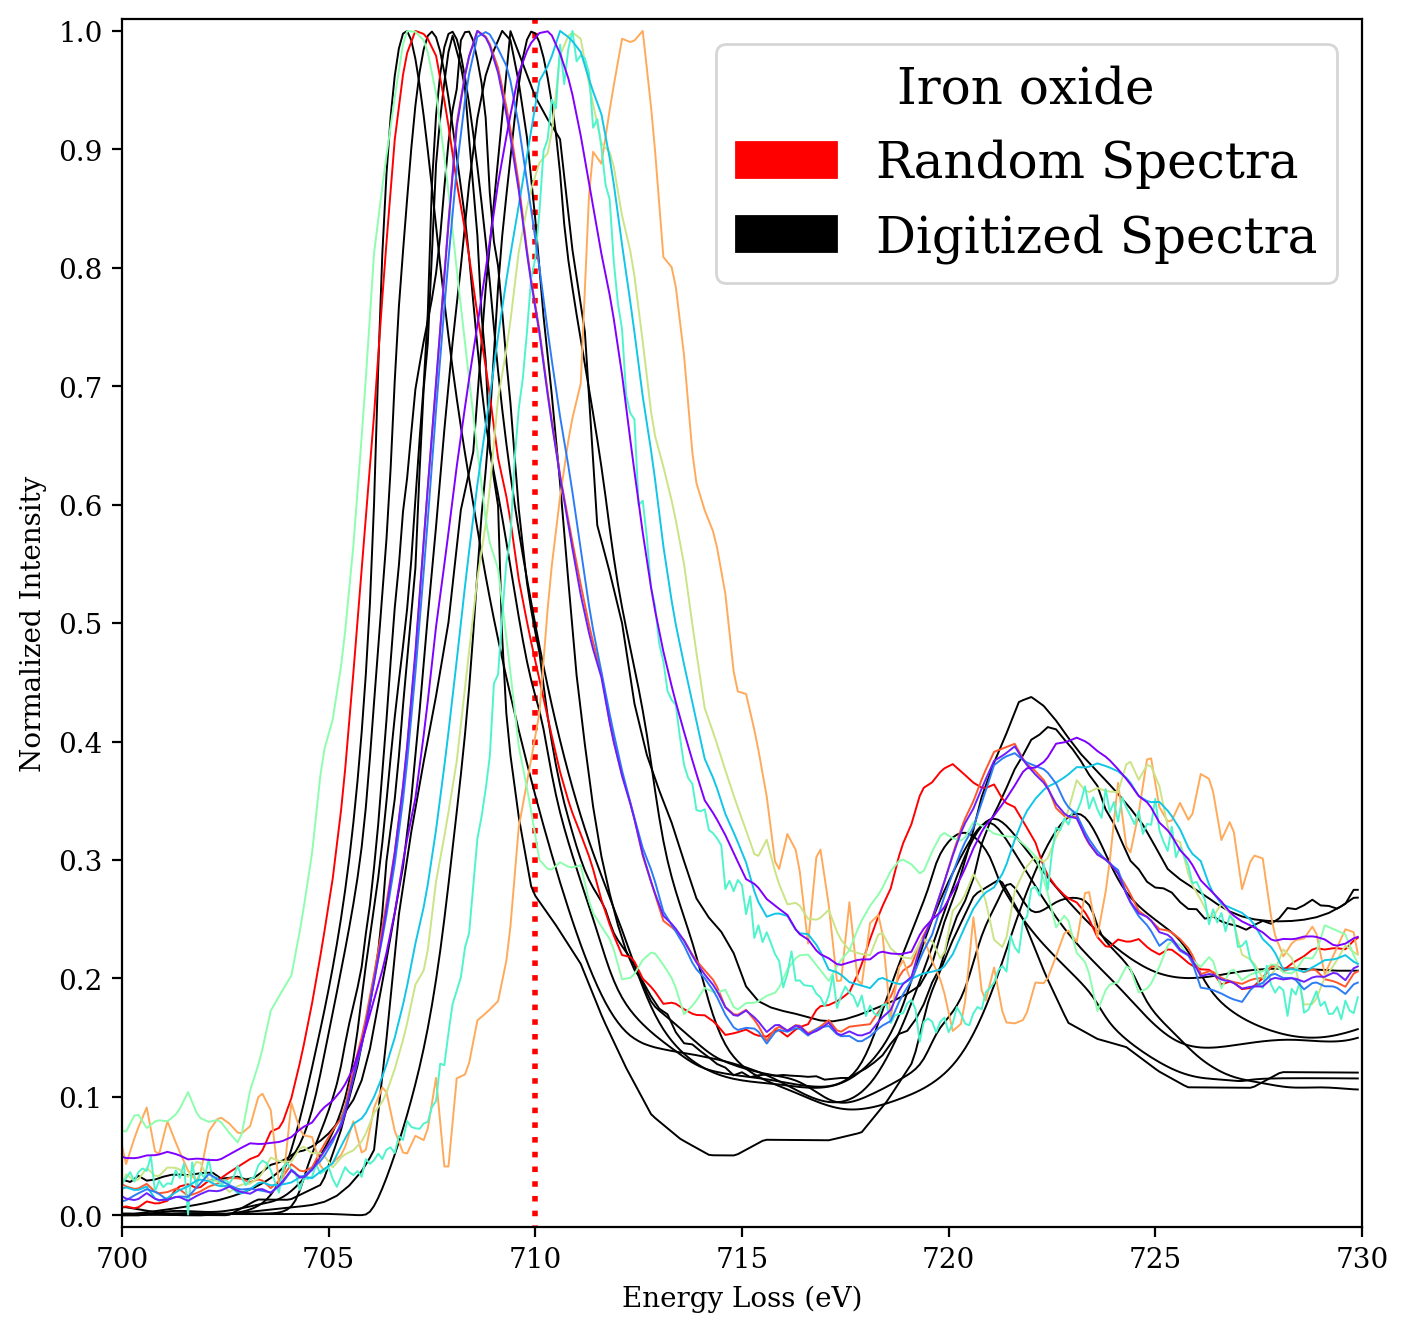

Figure not saved.


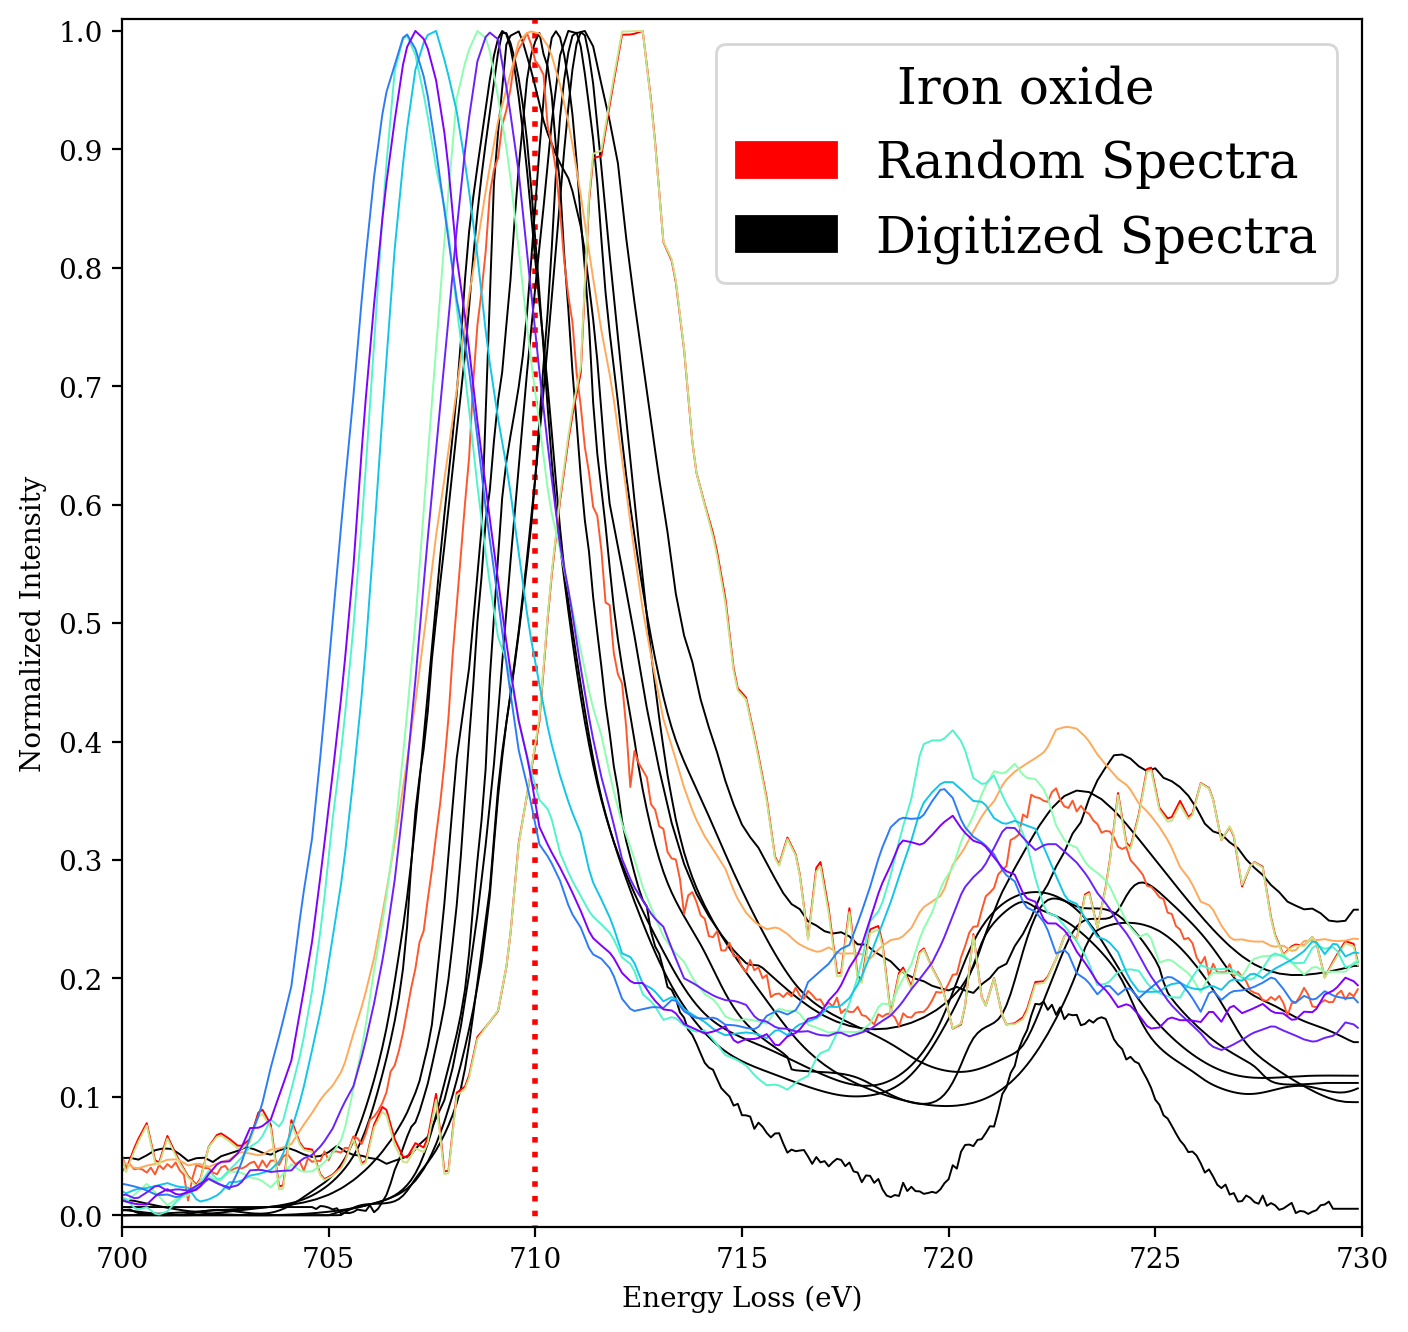

Figure not saved.


In [18]:
plot_randomly_spectra(Fe_All_c,10,wusti_dig)
plot_randomly_spectra(Fe_All_c,10,magne_dig)

## Test digitized spectra: 

In [ ]:
os.chdir(r"Gridsearch_results")

In [25]:
#Load gridsearch results: 
lin_set4 = joblib.load('lin_set4_ovr')
rbf_set4 = joblib.load('rbf_set4_ovr')

In [26]:
#Test digitized spectra with optimized estimators by Gridsearch:
test_svm(lin_set4.best_estimator_,fe_dig,labels_digfe)
test_svm(rbf_set4.best_estimator_,fe_dig,labels_digfe)

Test accuracy:  0.75 .
Test accuracy:  0.875 .


0.875

## Train and test a SVM model: 

In [27]:
trained_model = train_and_test_svm_model(Fe_All_c,labels,kernel='linear',C=0.1,test_size=.35)

Model test accuracy:  0.9842105263157894
Averaged 10-fold cross-validation accuracy: 0.96 (+/- 0.16)


## Optimize a SVM model: 

In [42]:
results_lin = optimize_SVM_clasifiers({"kernel":["linear"],"C":np.logspace(-3,4,8)},Fe_All,labels,file_save='heno')
results_rbf = optimize_SVM_clasifiers({"kernel":["rbf"],"C":np.logspace(-3,4,8),"gamma":np.logspace(-3,4,8)},Fe_All,labels,file_save='heno1')
results_sig = optimize_SVM_clasifiers({"kernel":["sigmoid"],"C":np.logspace(-3,4,8),"gamma":np.logspace(-3,4,8),"coef0":np.logspace(-3,4,8)},Fe_All,labels,file_save='heno2')

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  58 out of  80 | elapsed:    3.7s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  67 out of  80 | elapsed:    3.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  76 out of  80 | elapsed:    3.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.8s finished


Time comsuming of the Gridsearch:  3.9352259635925293 seconds. 

The best model is: 

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Gridsearch results saved.
Fitting 10 folds for each of 64 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   26.8s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   35.0s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

Time comsuming of the Gridsearch:  78.15633392333984 seconds. 

The best model is: 

SVC(C=10000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.001,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Gridsearch results saved.
Fitting 10 folds for each of 512 candidates, totalling 5120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   40.6s
[Parallel(n_jobs=-1)]: Done 233 tasks      | elapsed:  

Time comsuming of the Gridsearch:  913.2032415866852 seconds. 

The best model is: 

SVC(C=100.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.001, decision_function_shape='ovr', degree=3, gamma=0.01,
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
Gridsearch results saved.


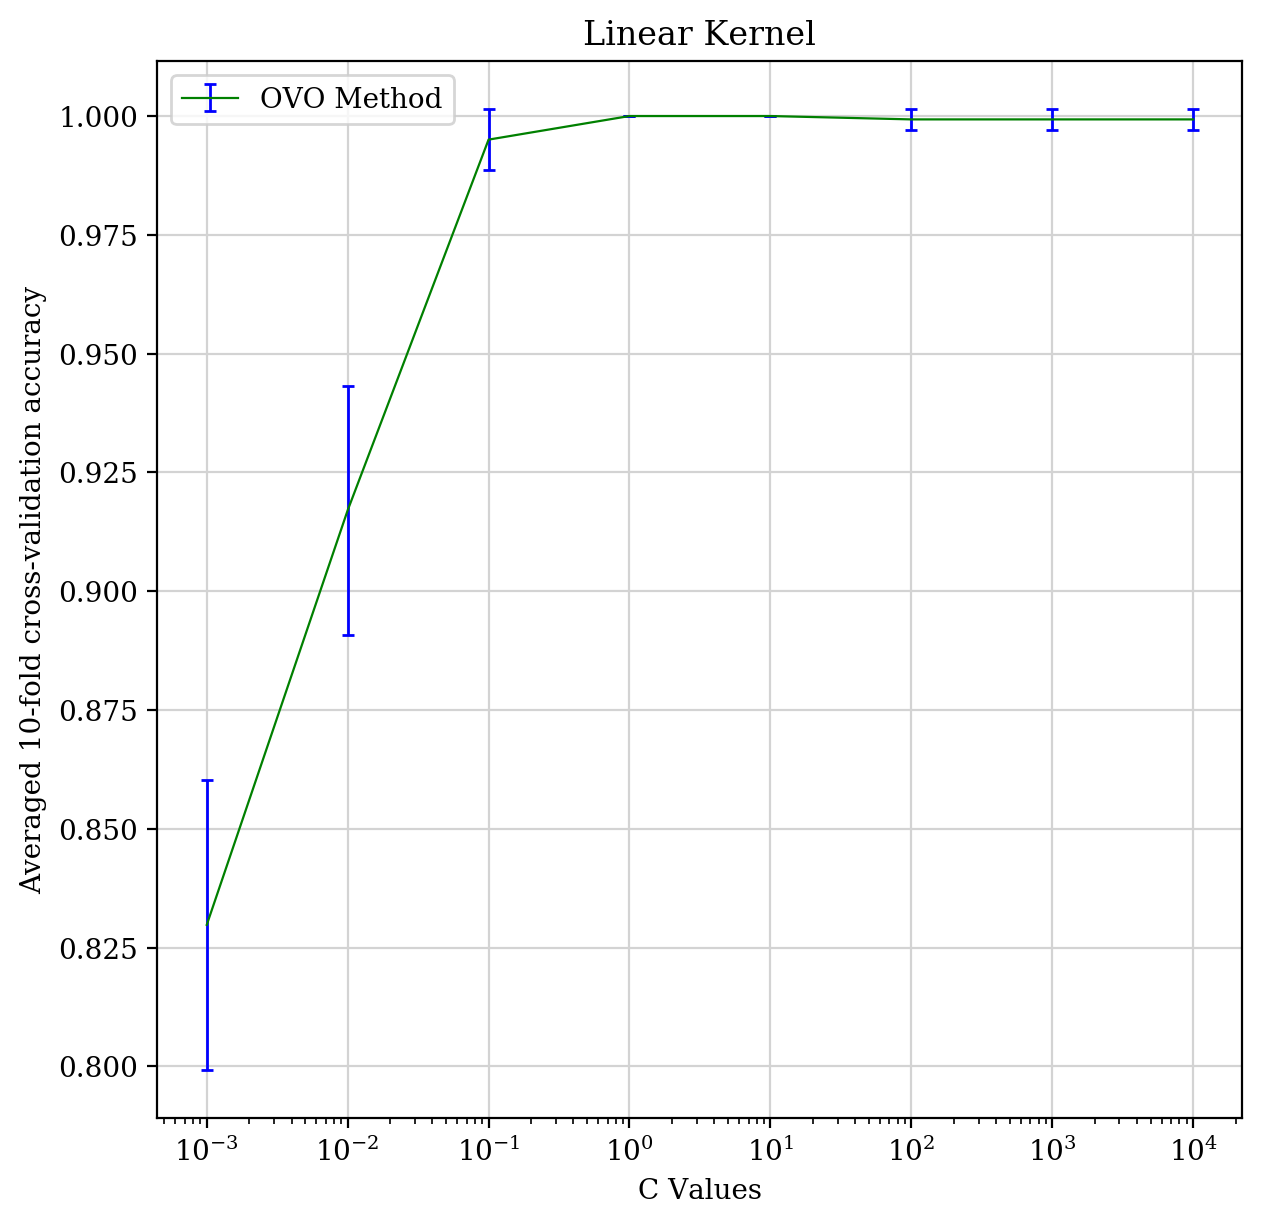

The optimum hyperparameters found by the Gridsearch are:
{'C': 1.0, 'kernel': 'linear'} 

The best estimator gets an score of:  1.0
Figure not saved.


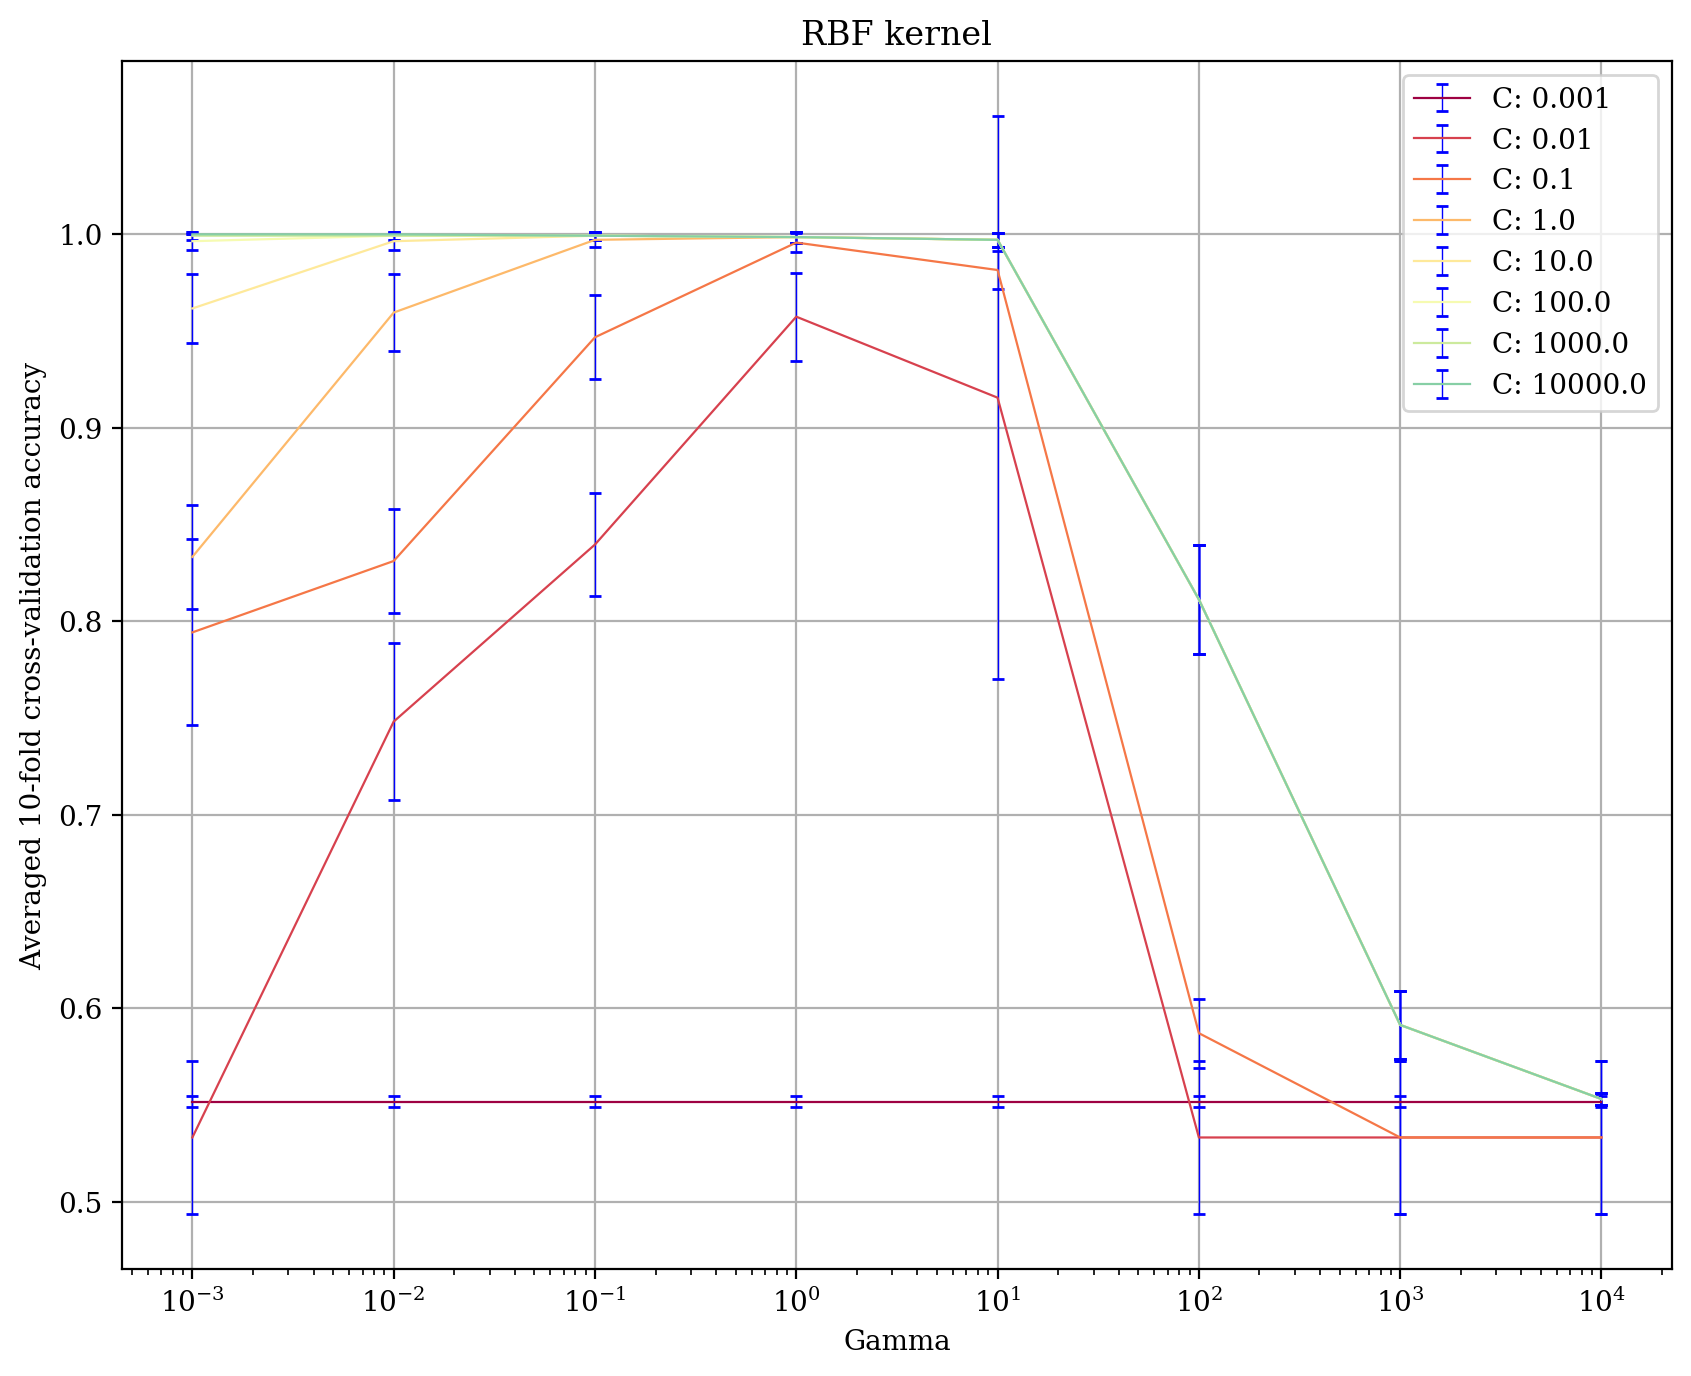

The optimum hyperparameters found by the Gridsearch are:
{'C': 10000.0, 'gamma': 0.001, 'kernel': 'rbf'}
The best estimator gets an score of:  1.0
Figure not saved.


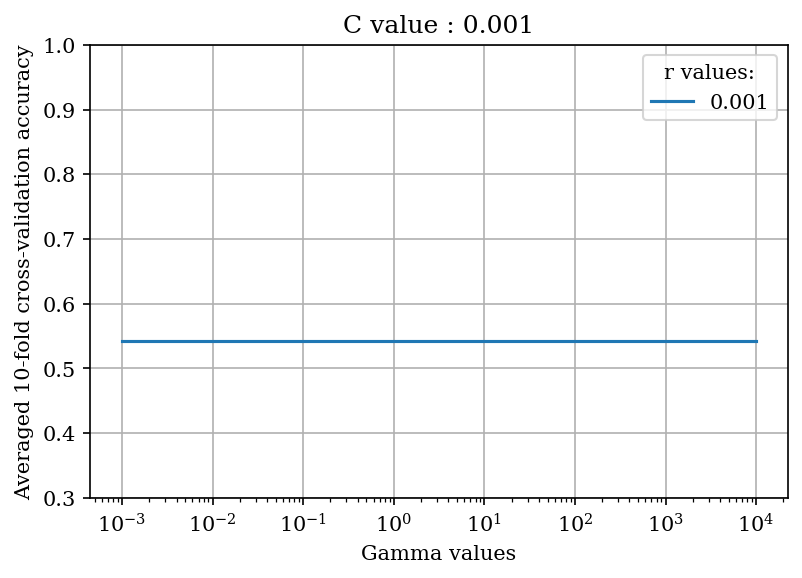

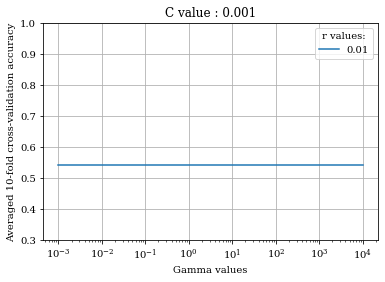

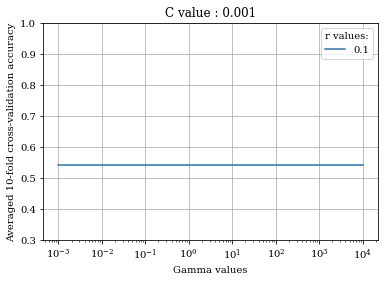

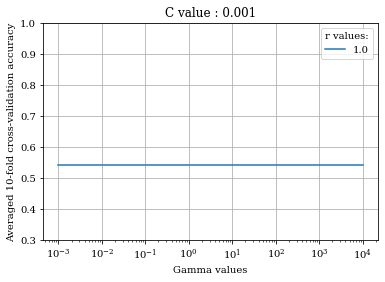

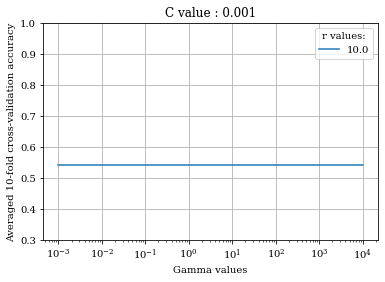

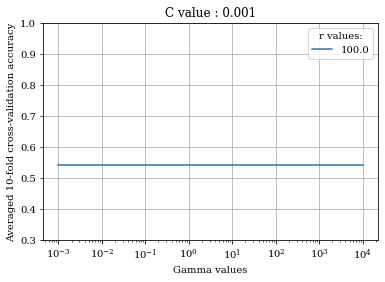

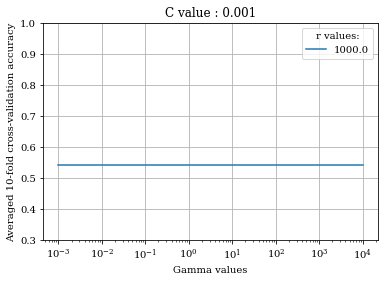

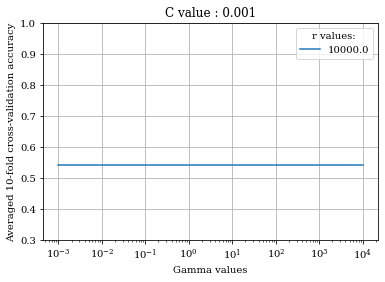

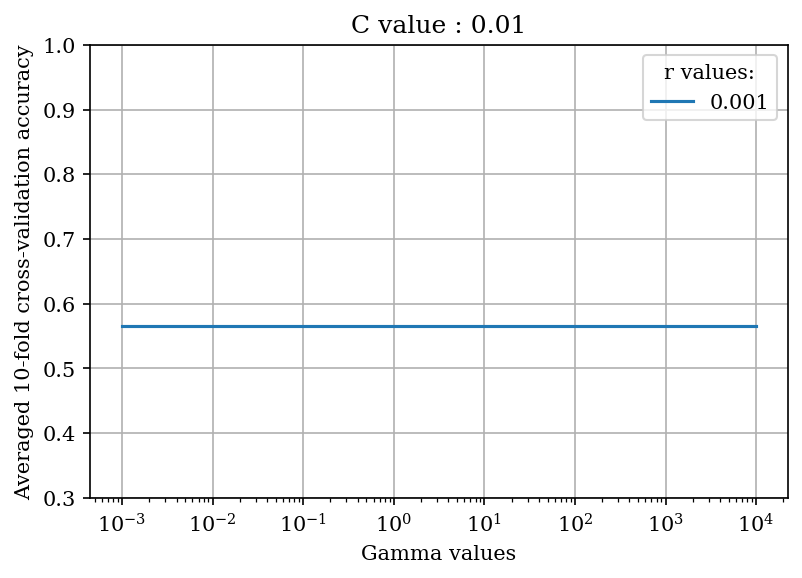

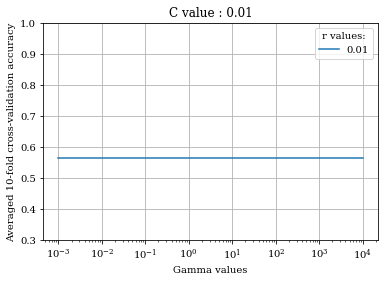

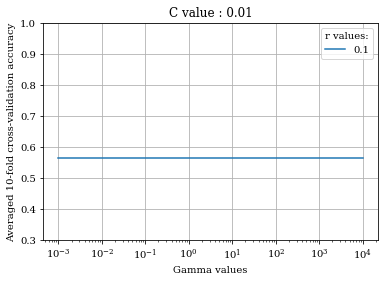

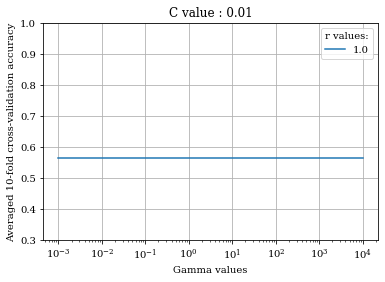

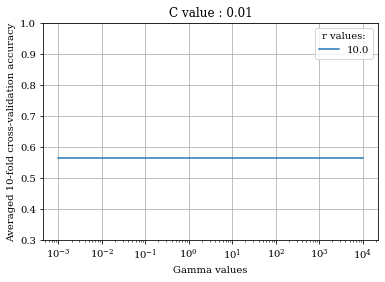

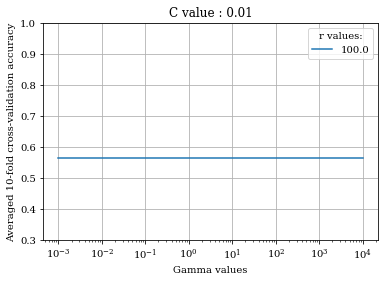

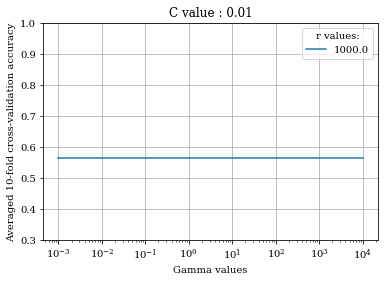

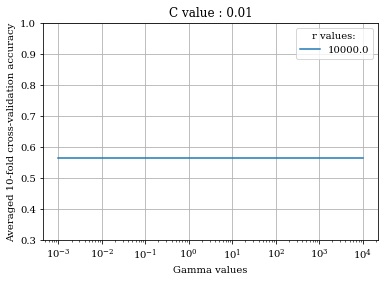

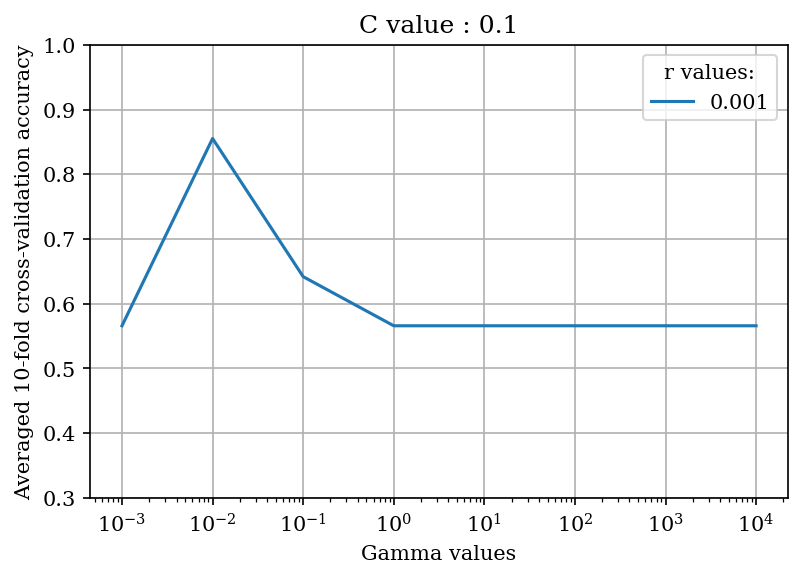

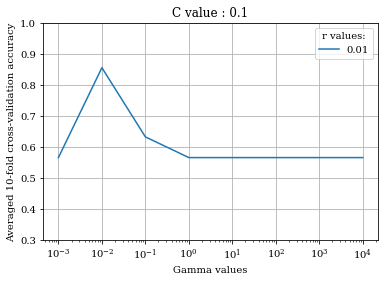

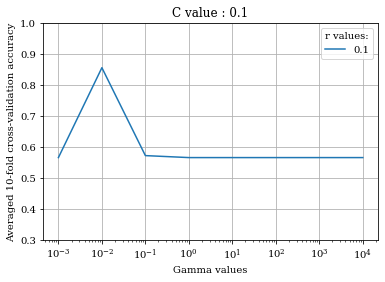

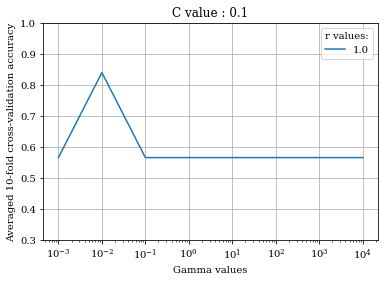

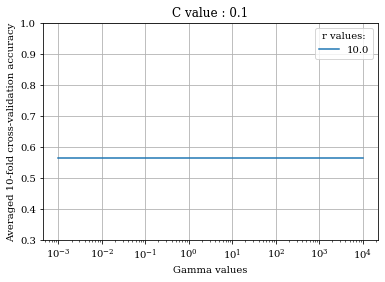

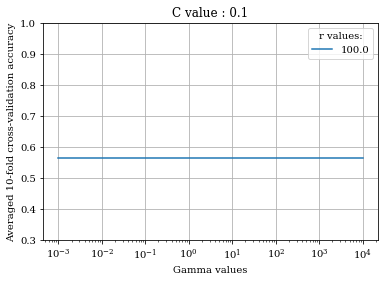

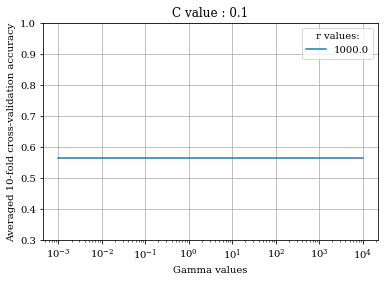

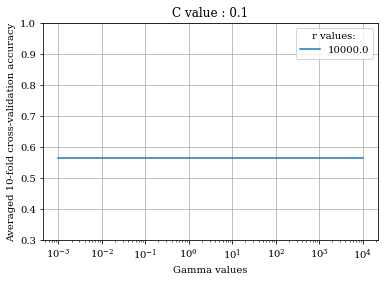

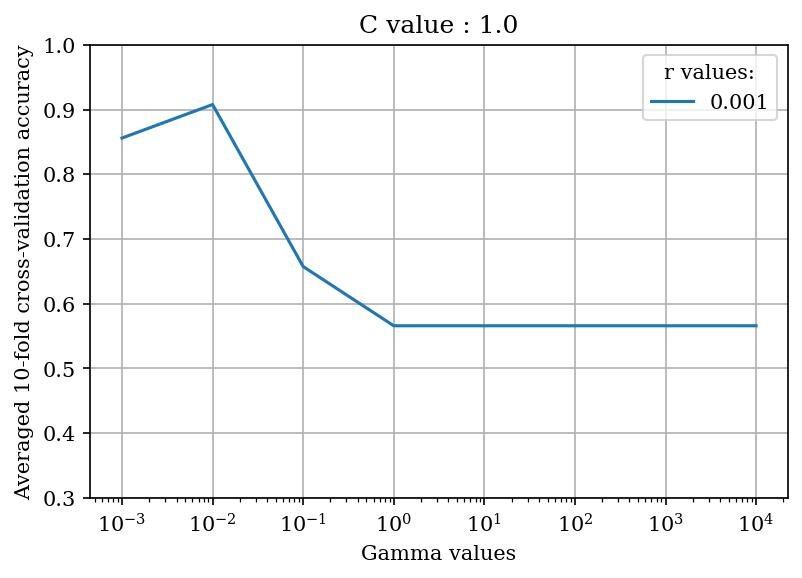

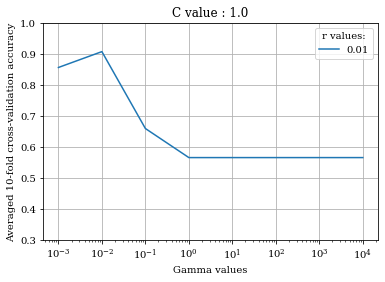

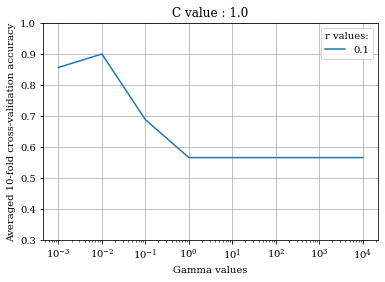

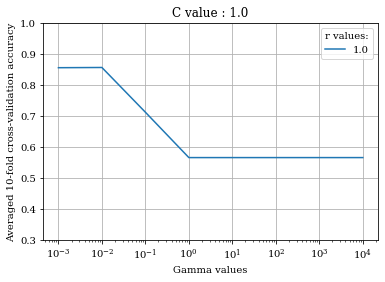

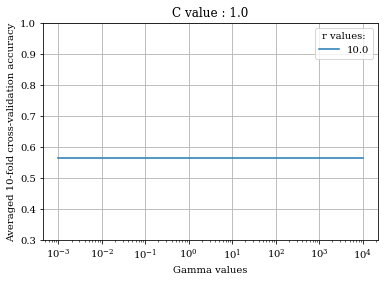

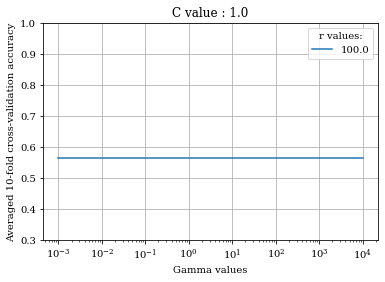

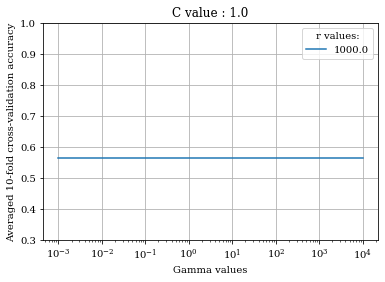

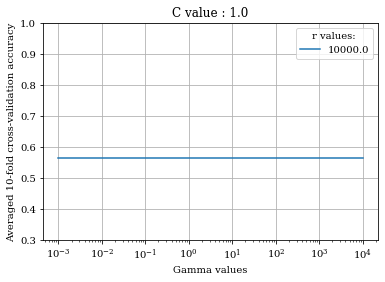

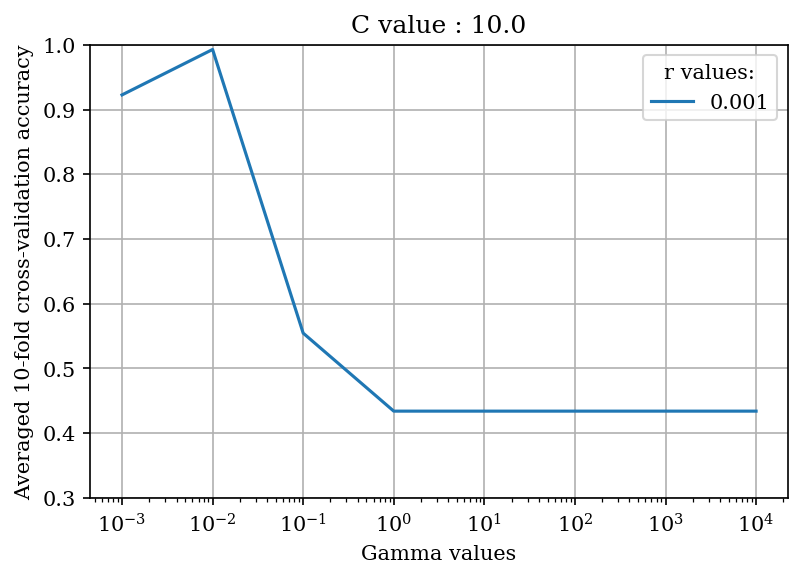

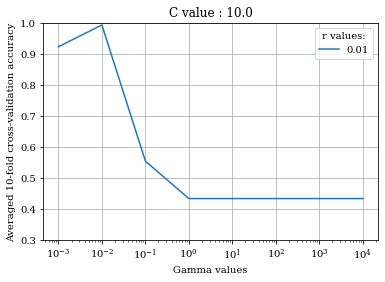

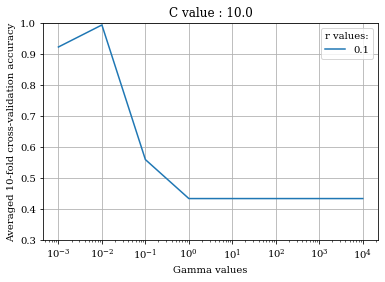

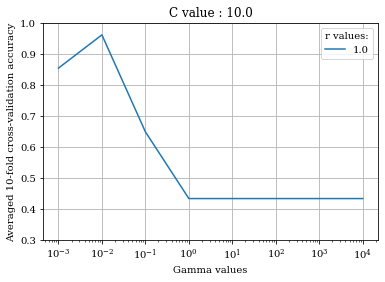

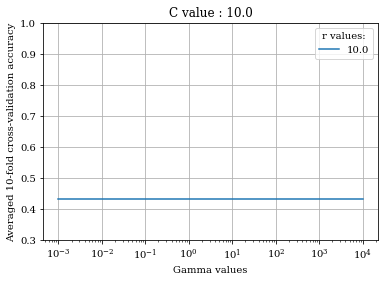

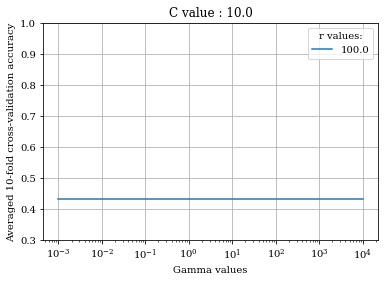

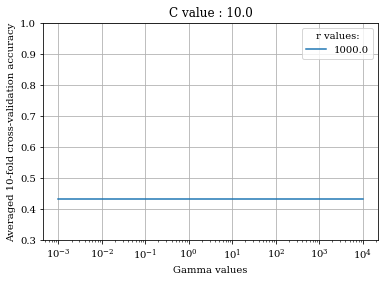

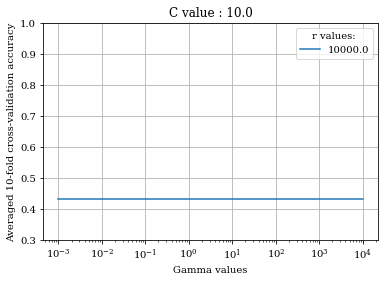

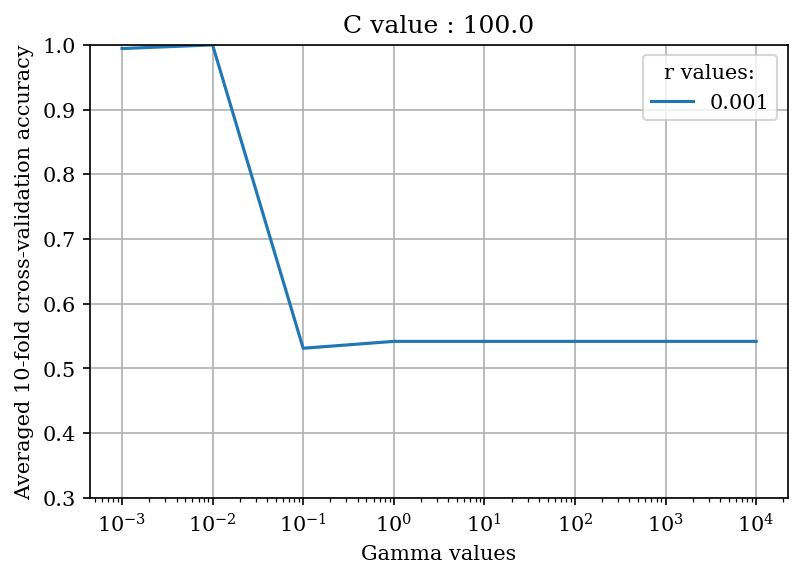

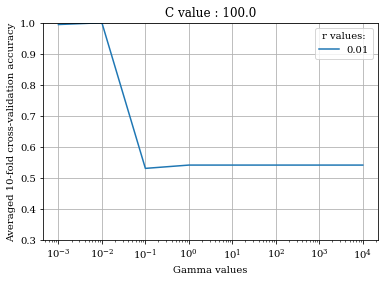

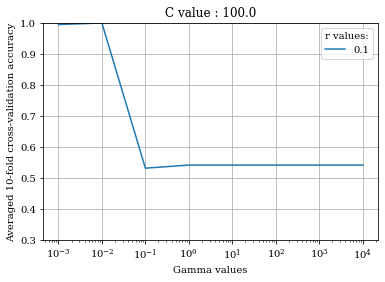

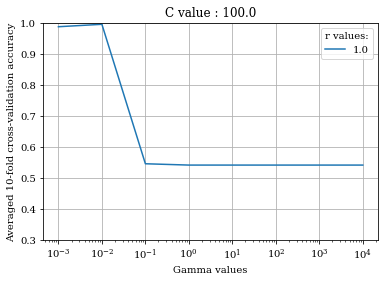

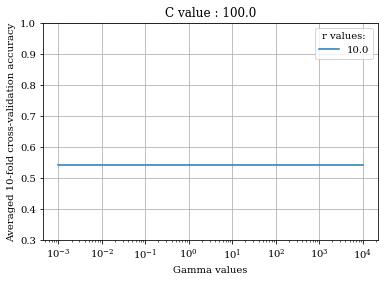

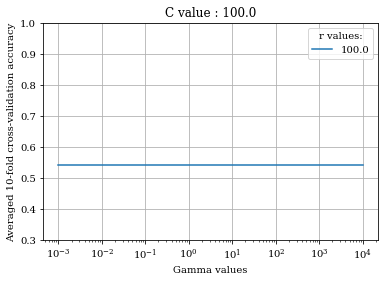

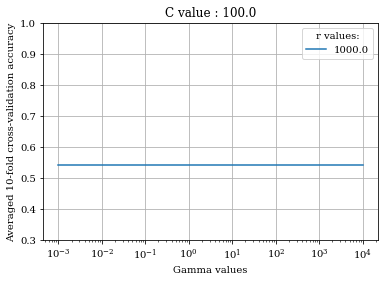

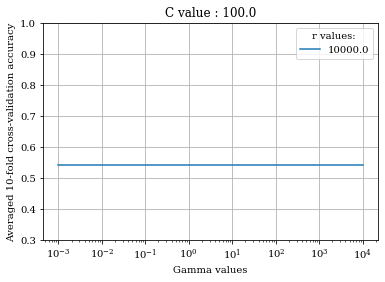

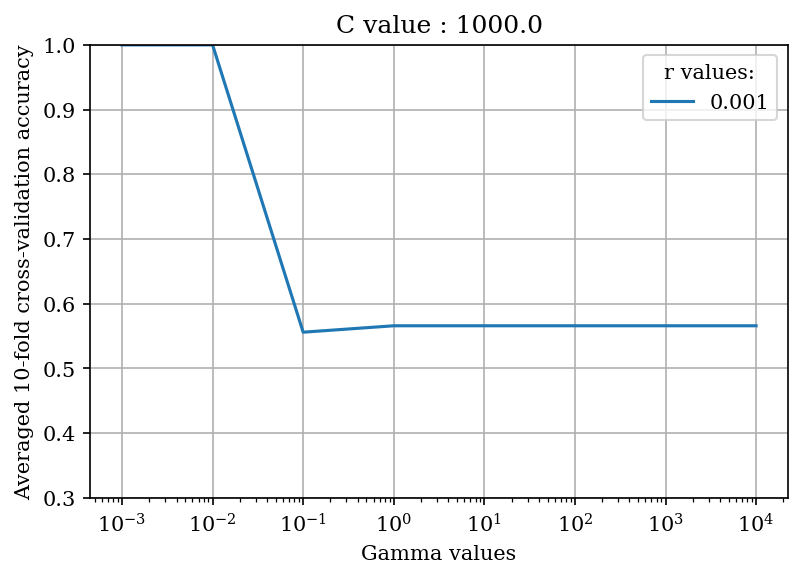

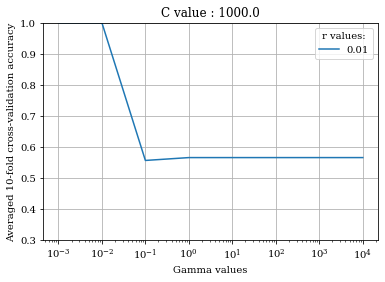

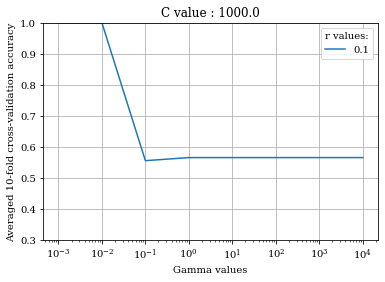

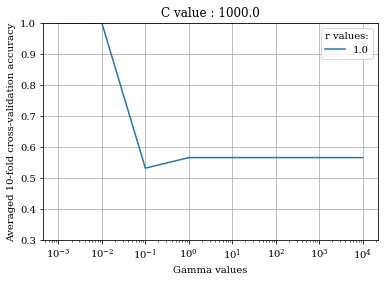

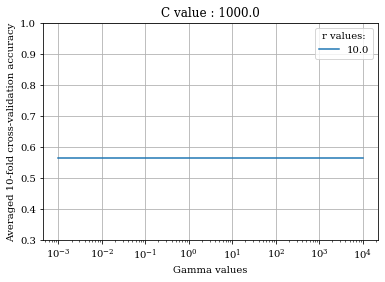

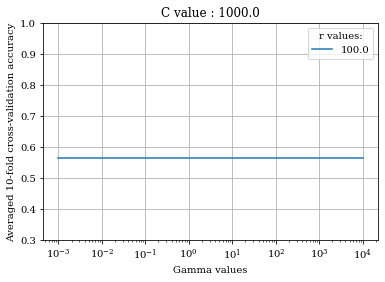

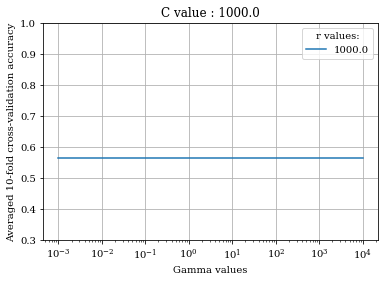

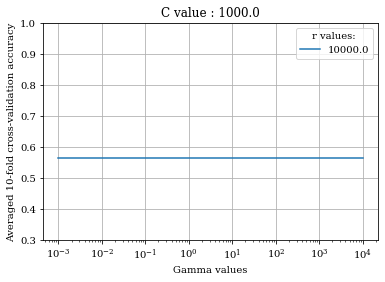

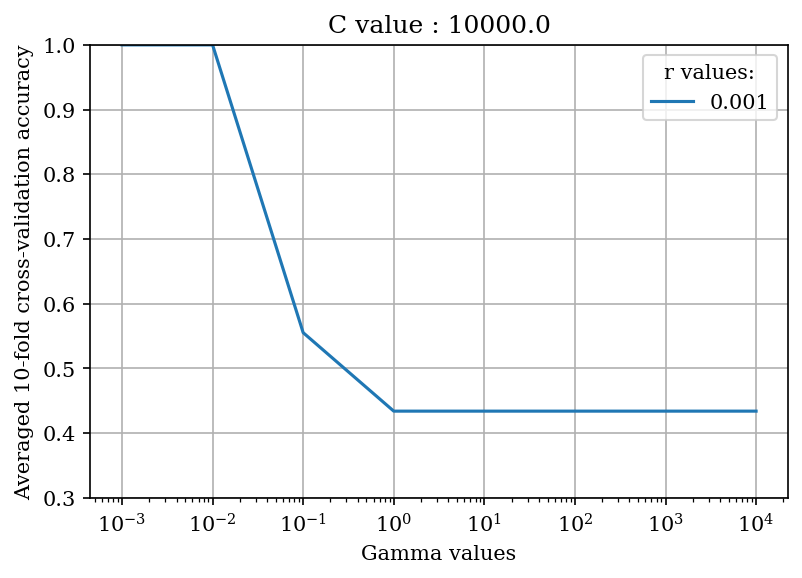

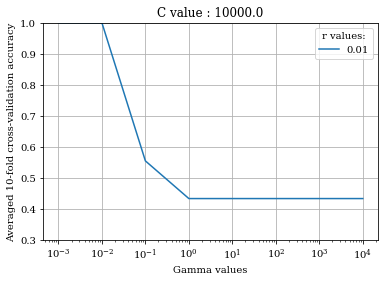

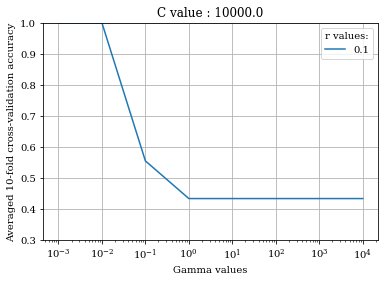

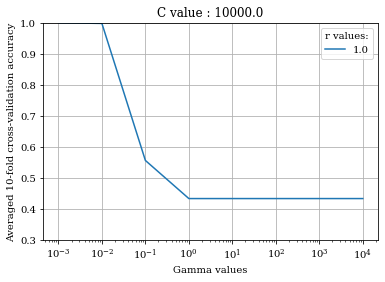

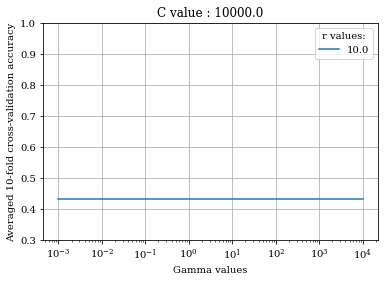

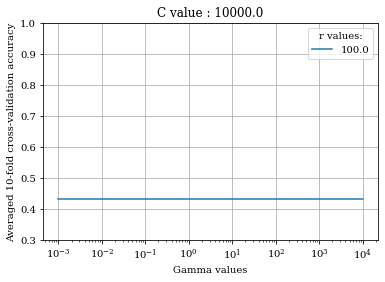

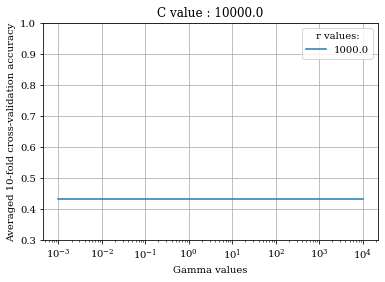

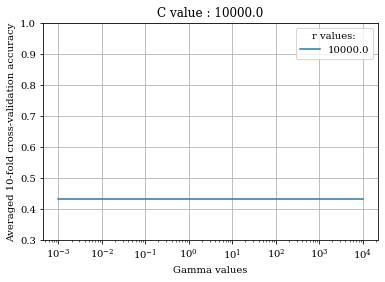

The optimum hyperparameters found by the Gridsearch are:
{'C': 100.0, 'coef0': 0.001, 'gamma': 0.01, 'kernel': 'sigmoid'}
The best estimator gets an score of:  1.0
Figure not saved.


In [43]:
plot_gridsearch_results(results_lin)
plot_gridsearch_results(results_rbf)
plot_gridsearch_results(results_sig)

## Plot gridsearch results from saved models:

In [44]:
#Load gridsearch results: 
lin_set3 = joblib.load('lin_set3_ovr')
lin_set4 = joblib.load('lin_set4_ovr')
rbf_set3 = joblib.load('rbf_set3_ovr')
rbf_set4 = joblib.load('rbf_set4_ovr')

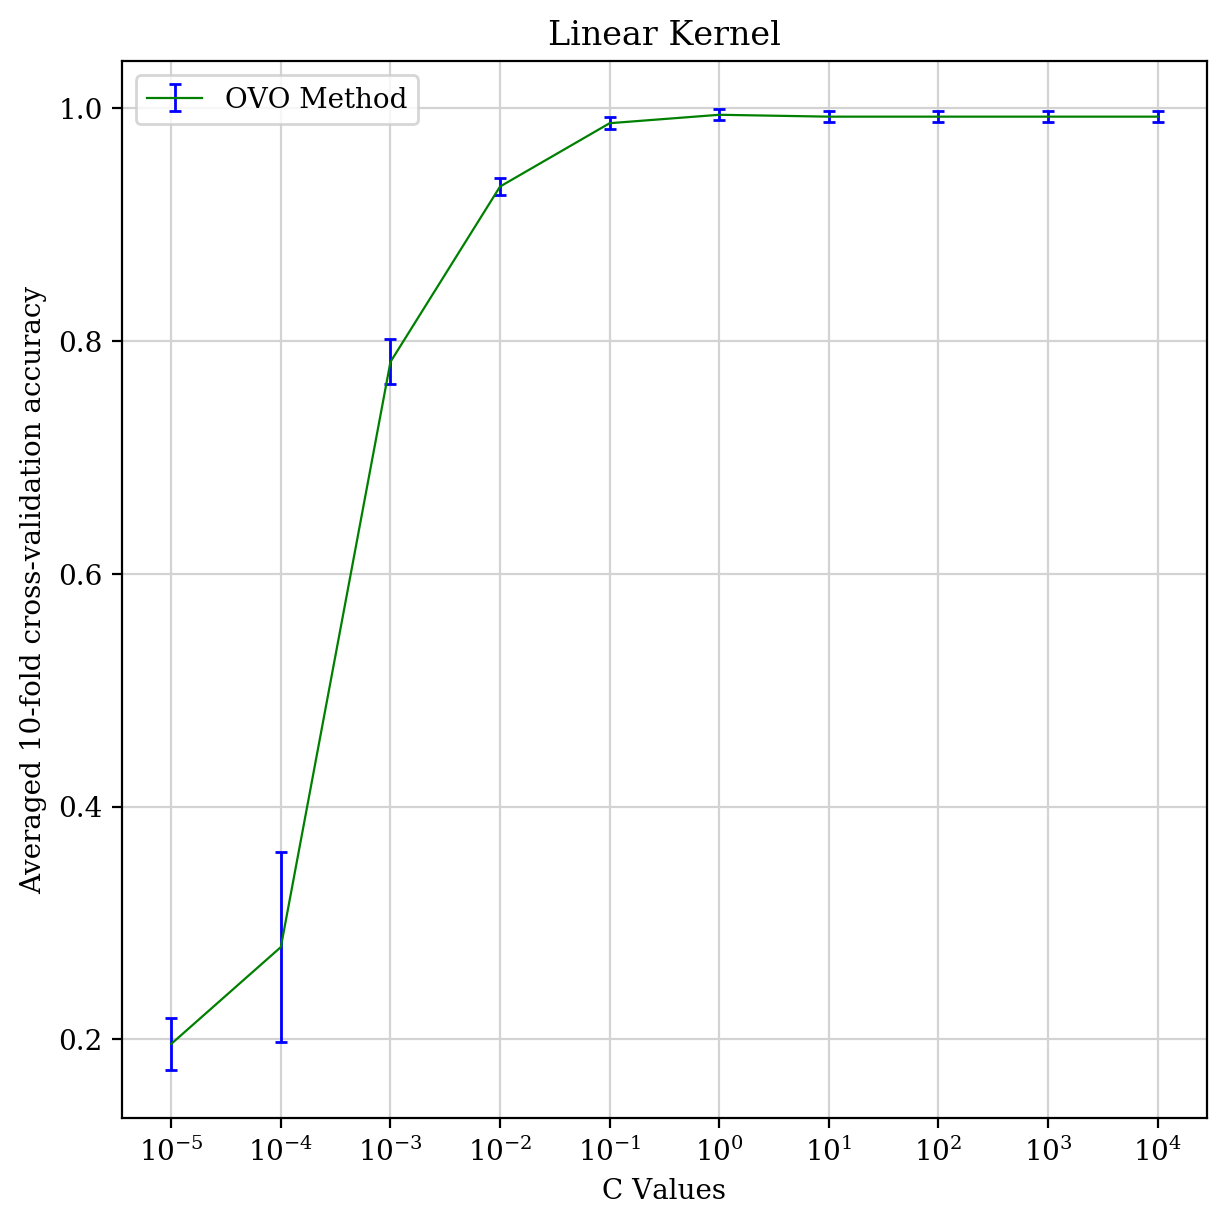

The optimum hyperparameters found by the Gridsearch are:
{'C': 1.0, 'kernel': 'linear'} 

The best estimator gets an score of:  0.9943692525007928
Figure not saved.


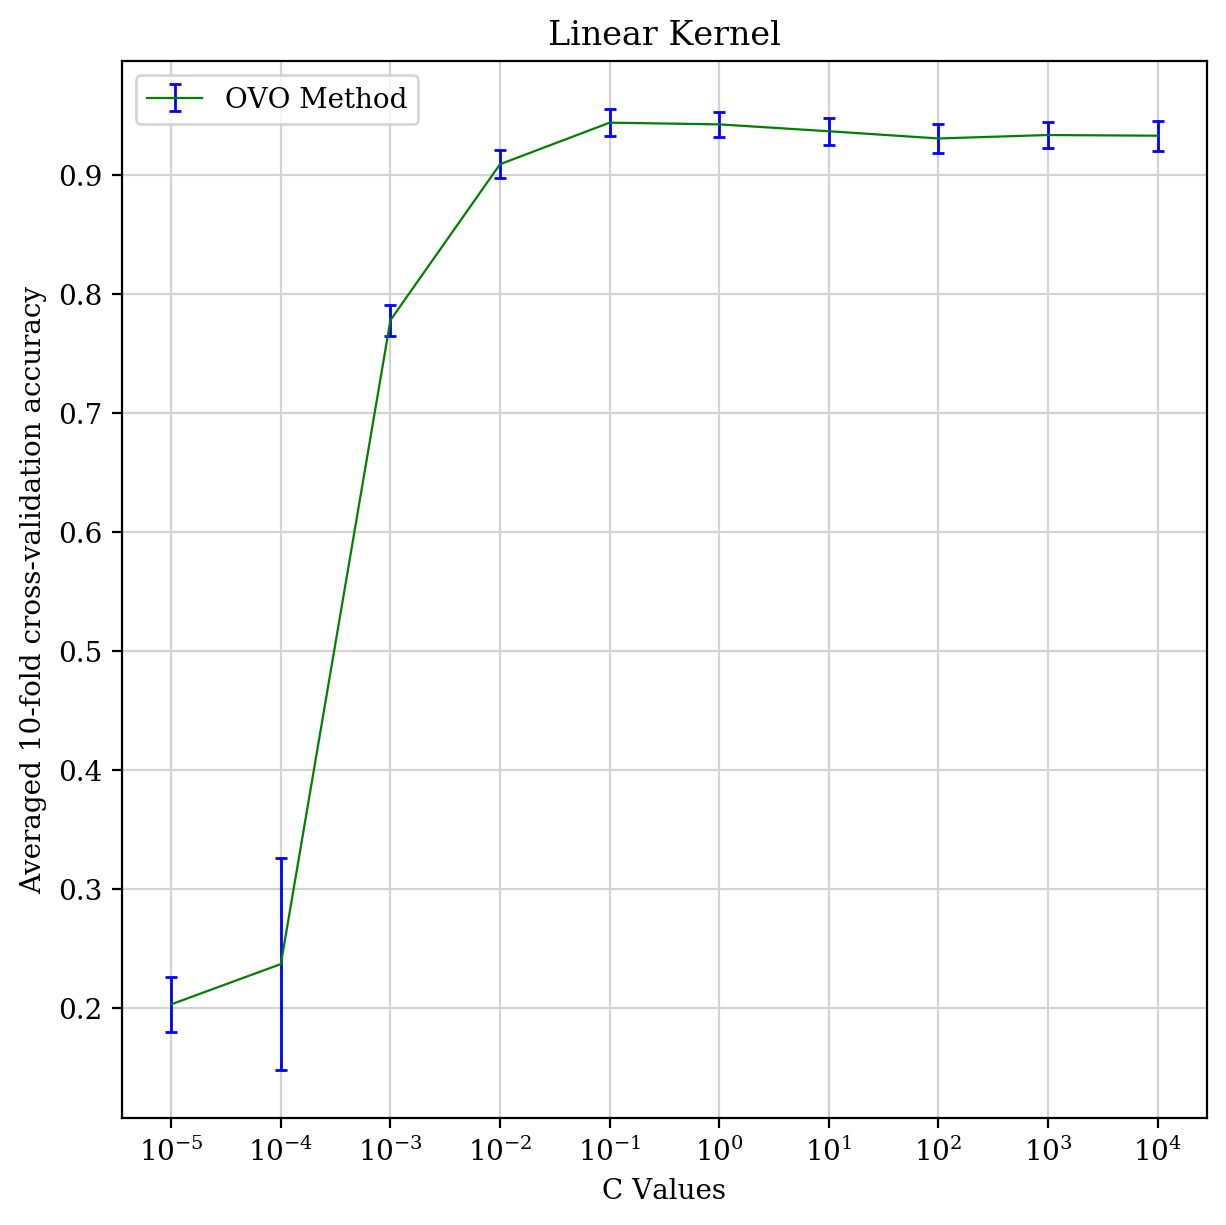

The optimum hyperparameters found by the Gridsearch are:
{'C': 0.1, 'kernel': 'linear'} 

The best estimator gets an score of:  0.9442712931651981
Figure not saved.


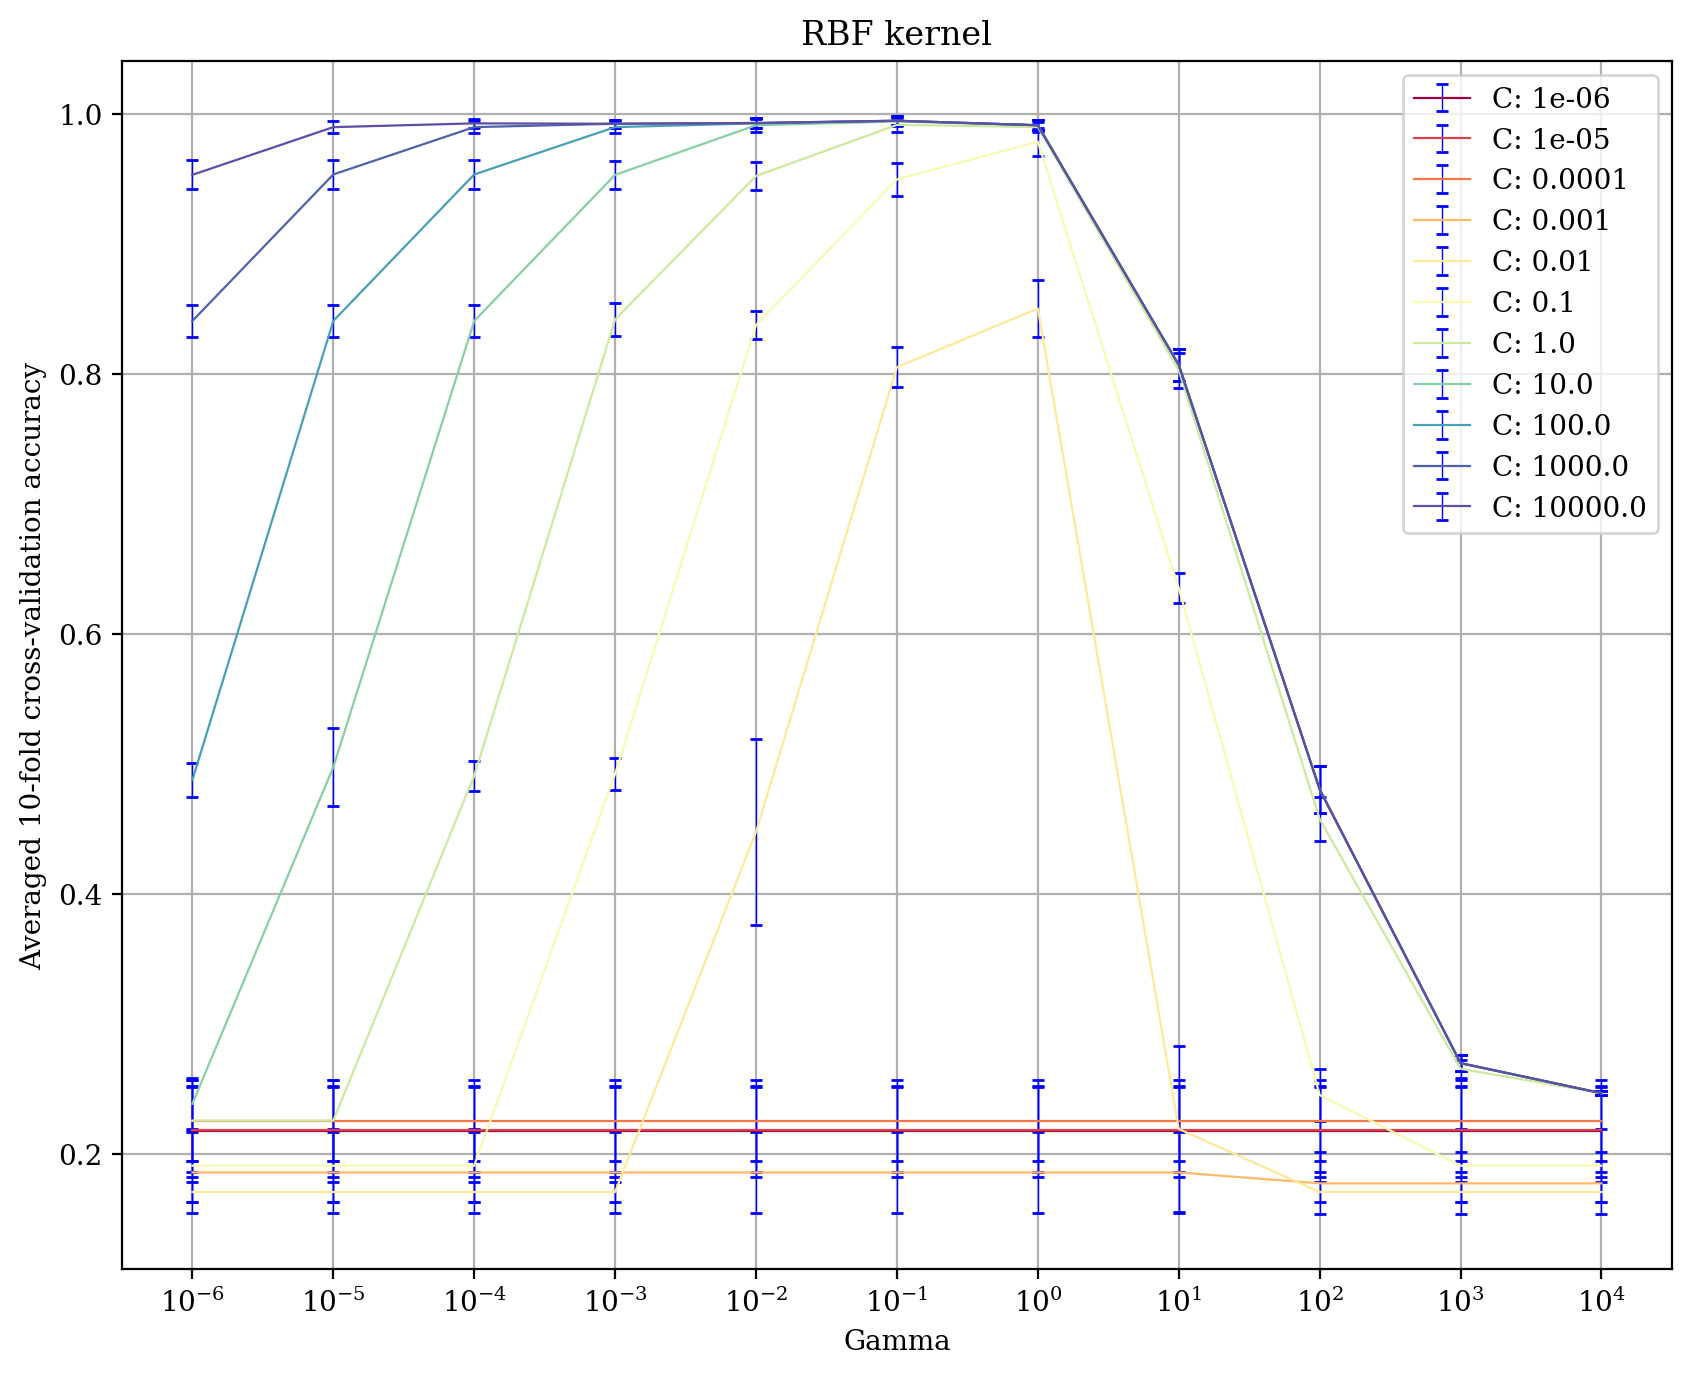

The optimum hyperparameters found by the Gridsearch are:
{'C': 100.0, 'gamma': 0.1, 'kernel': 'rbf'}
The best estimator gets an score of:  0.9945111692292314
Figure not saved.


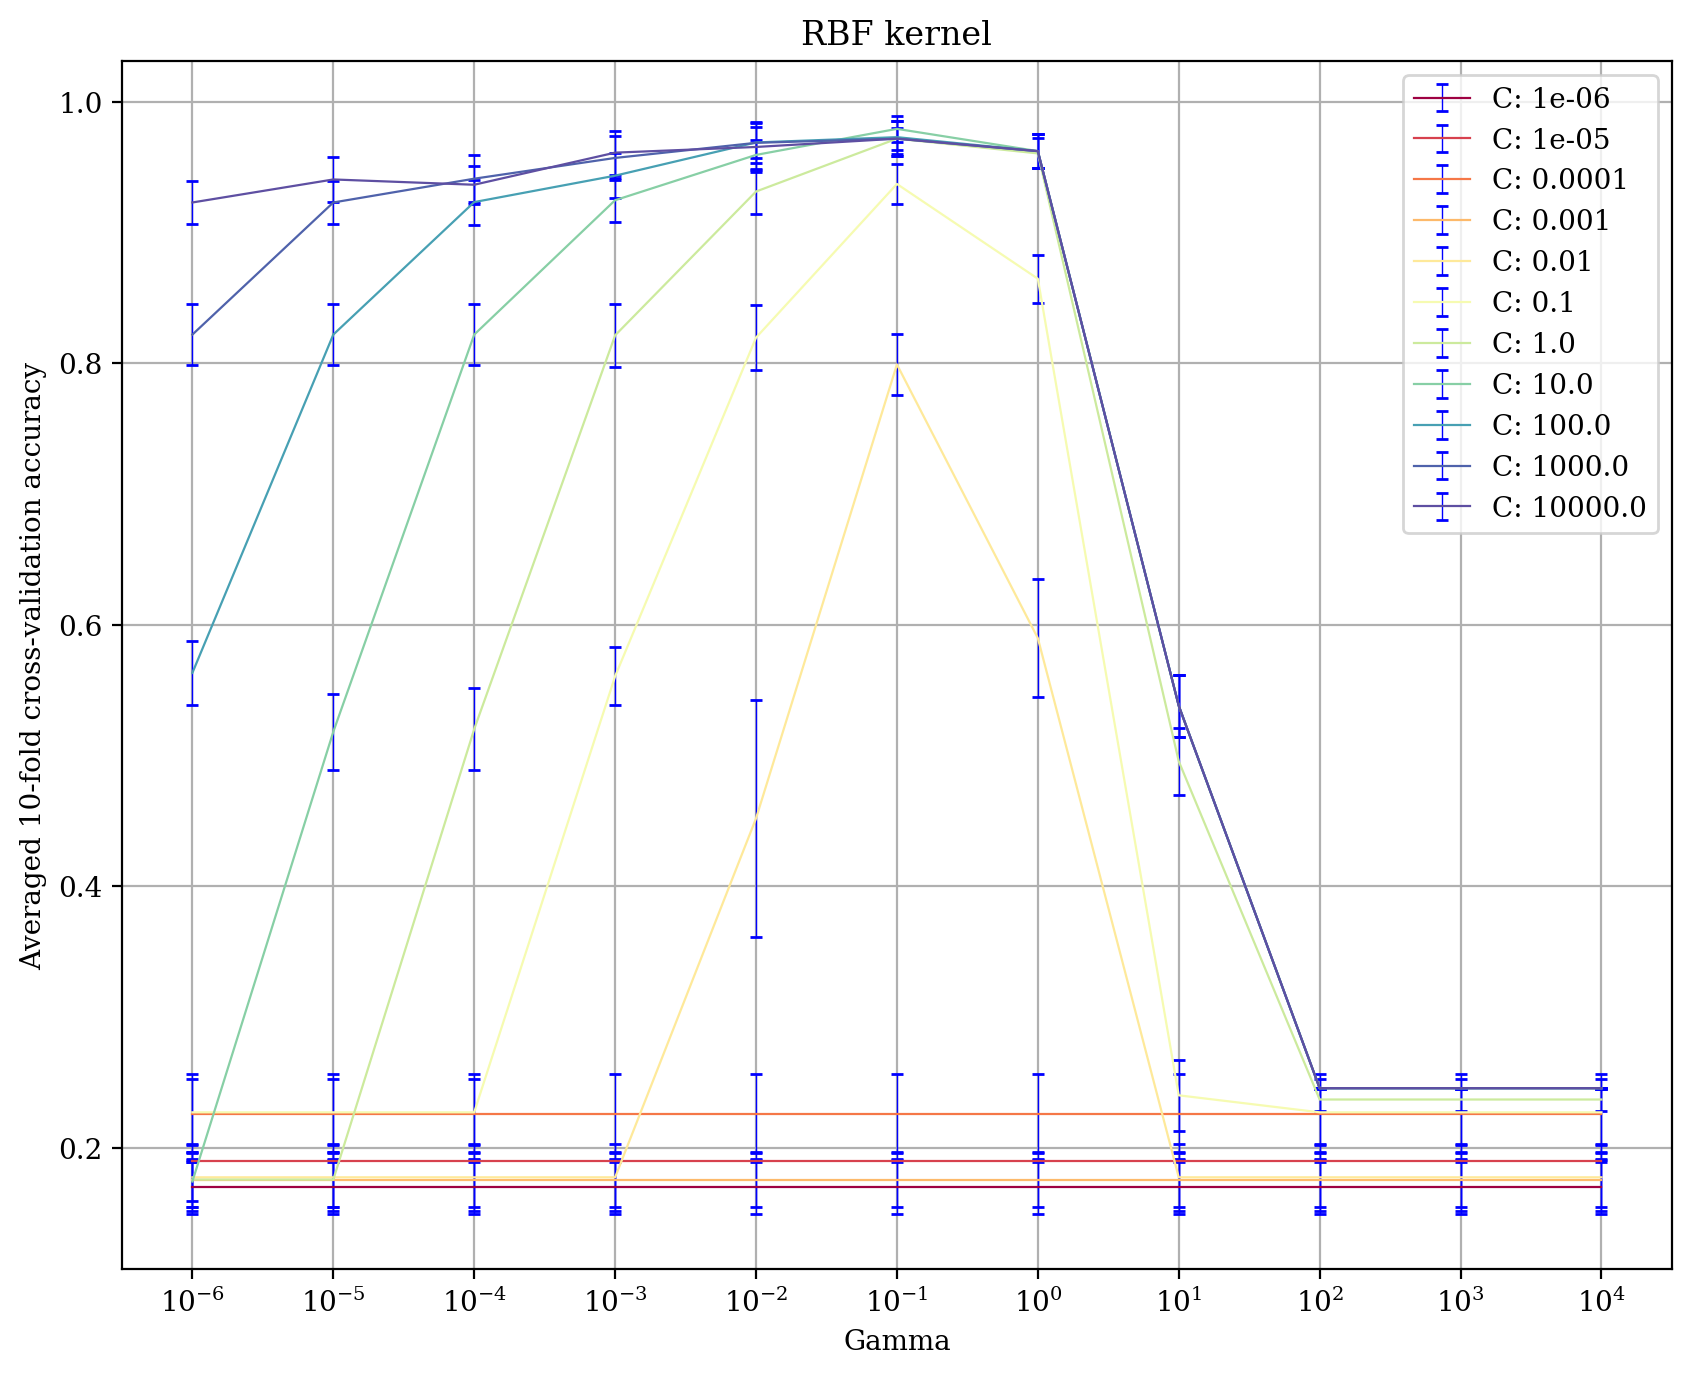

The optimum hyperparameters found by the Gridsearch are:
{'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}
The best estimator gets an score of:  0.9792107411170896
Figure not saved.


In [45]:
plot_gridsearch_results(lin_set3)
plot_gridsearch_results(lin_set4)
plot_gridsearch_results(rbf_set3)
plot_gridsearch_results(rbf_set4)

In [46]:
#Load gridsearch results: 
lin_set1 = joblib.load('lin_set1_ovr')
lin_set2 = joblib.load('lin_set2_ovr')
rbf_set1 = joblib.load('rbf_set1_ovr')
rbf_set2 = joblib.load('rbf_set2_ovr')

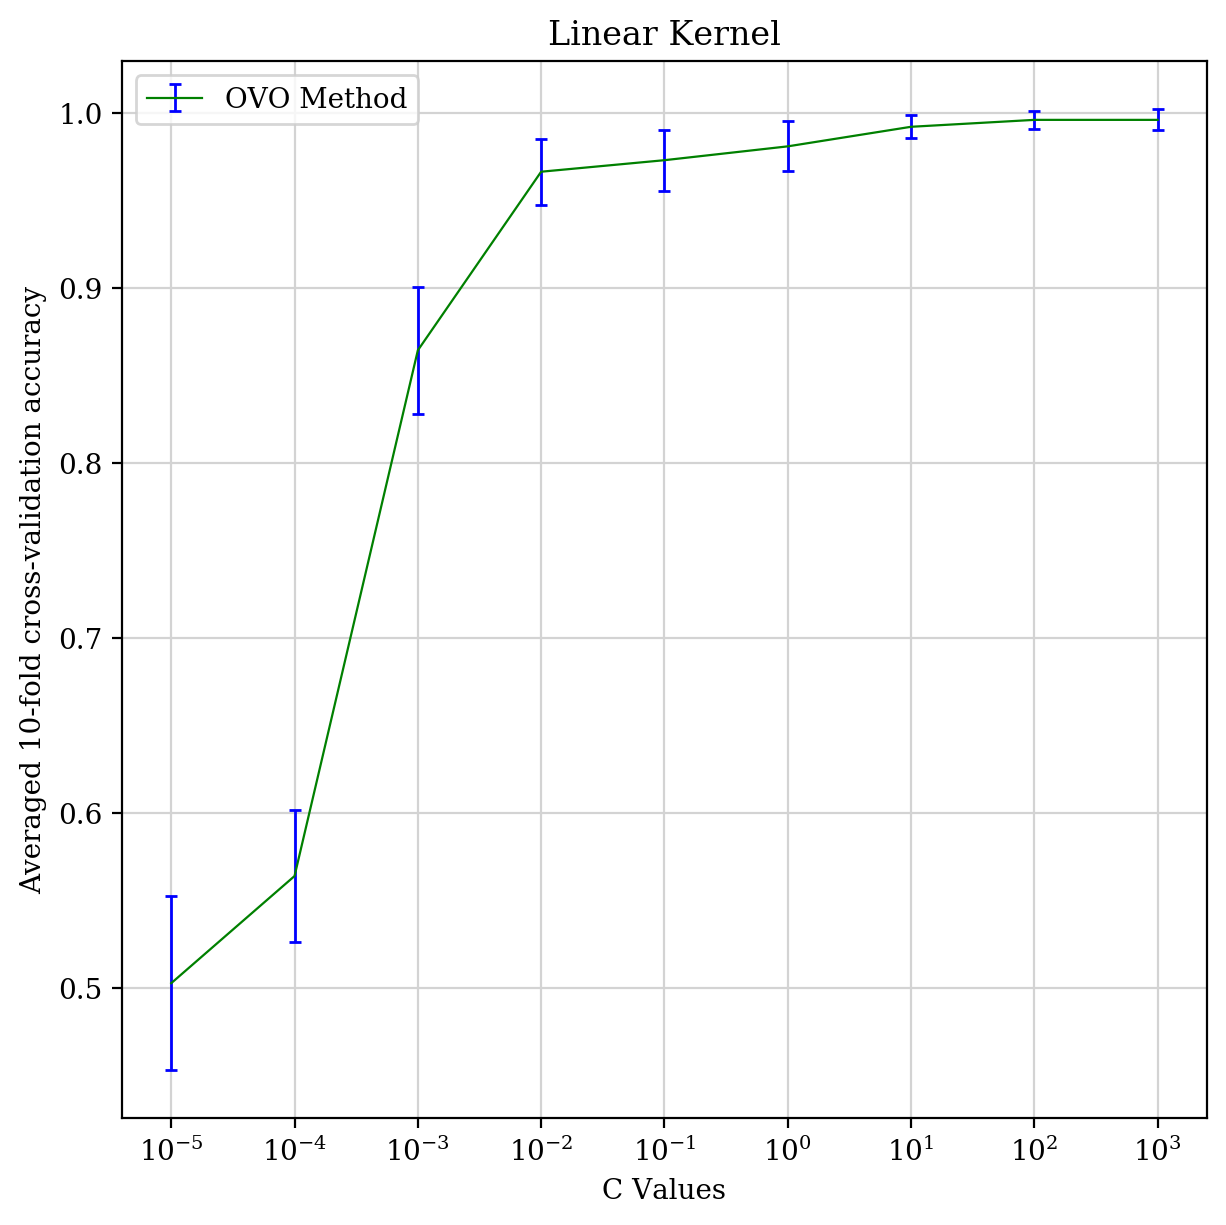

The optimum hyperparameters found by the Gridsearch are:
{'C': 100.0, 'kernel': 'linear'} 

The best estimator gets an score of:  0.9960439177413732
Figure not saved.


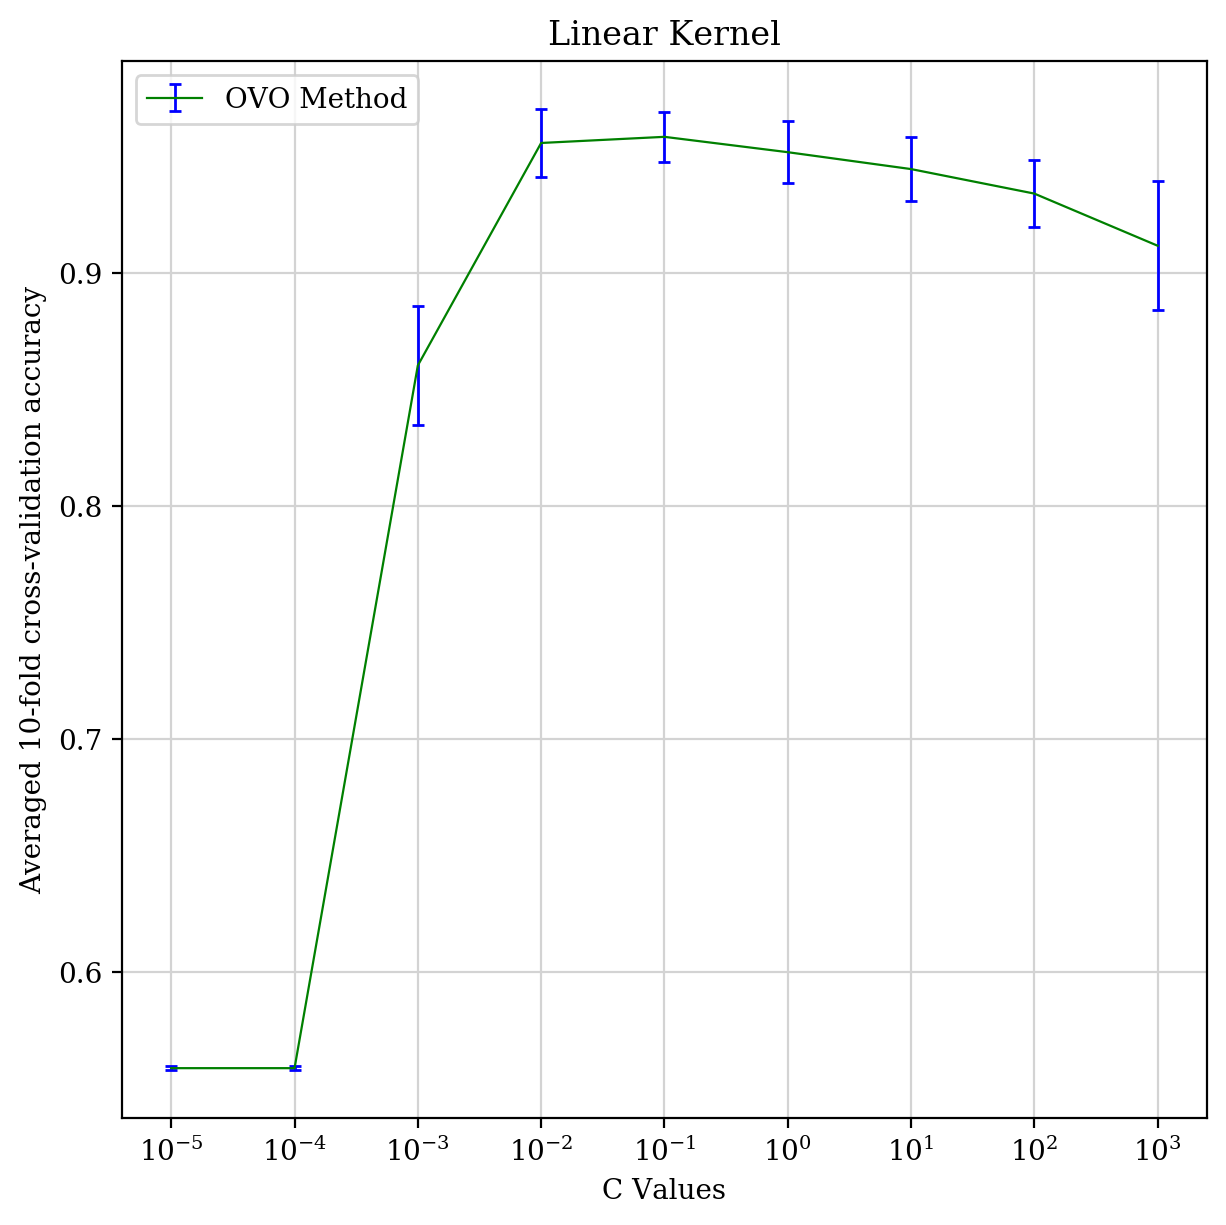

The optimum hyperparameters found by the Gridsearch are:
{'C': 0.1, 'kernel': 'linear'} 

The best estimator gets an score of:  0.9585177762286511
Figure not saved.


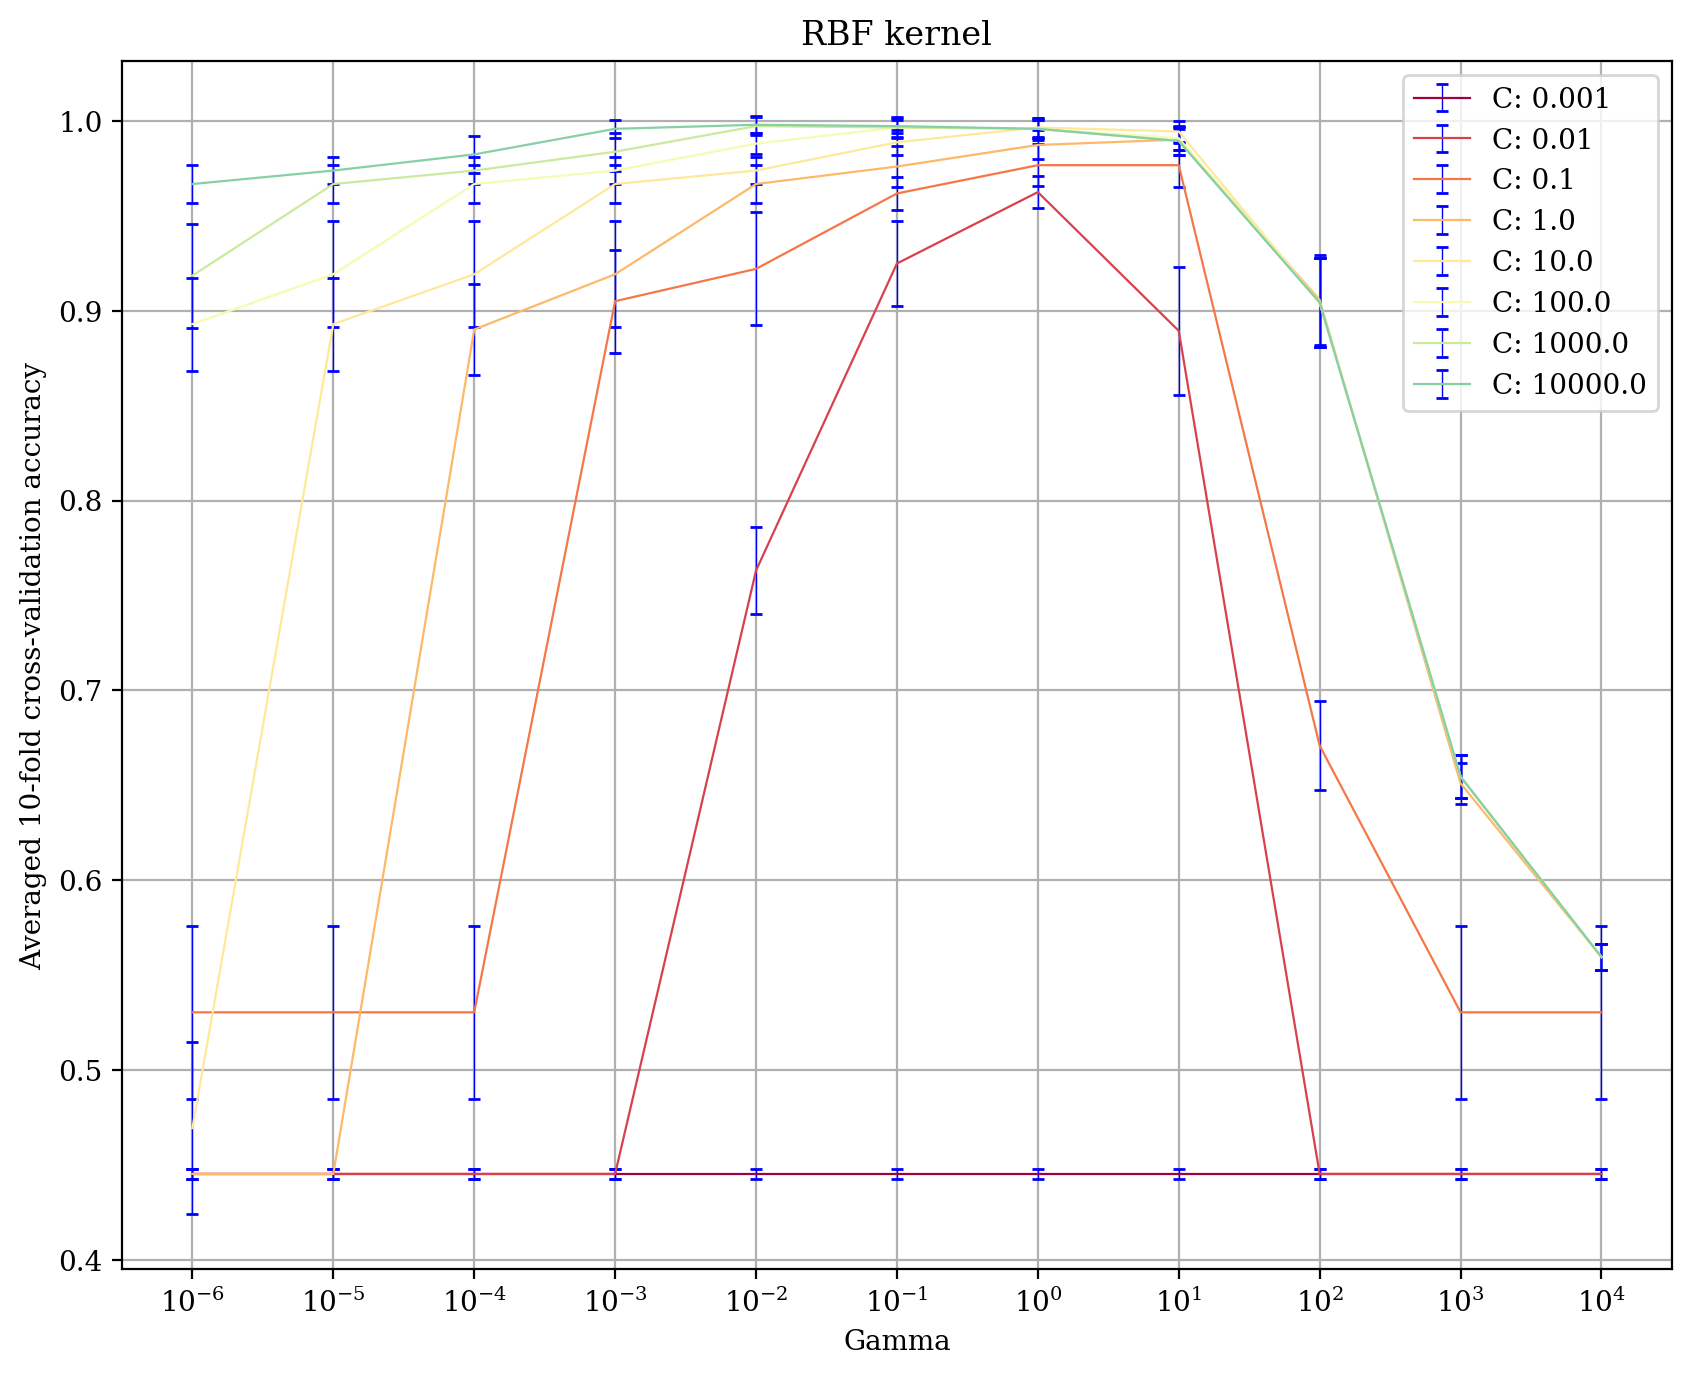

The optimum hyperparameters found by the Gridsearch are:
{'C': 10000.0, 'gamma': 0.01, 'kernel': 'rbf'}
The best estimator gets an score of:  0.997872340425532
Figure not saved.


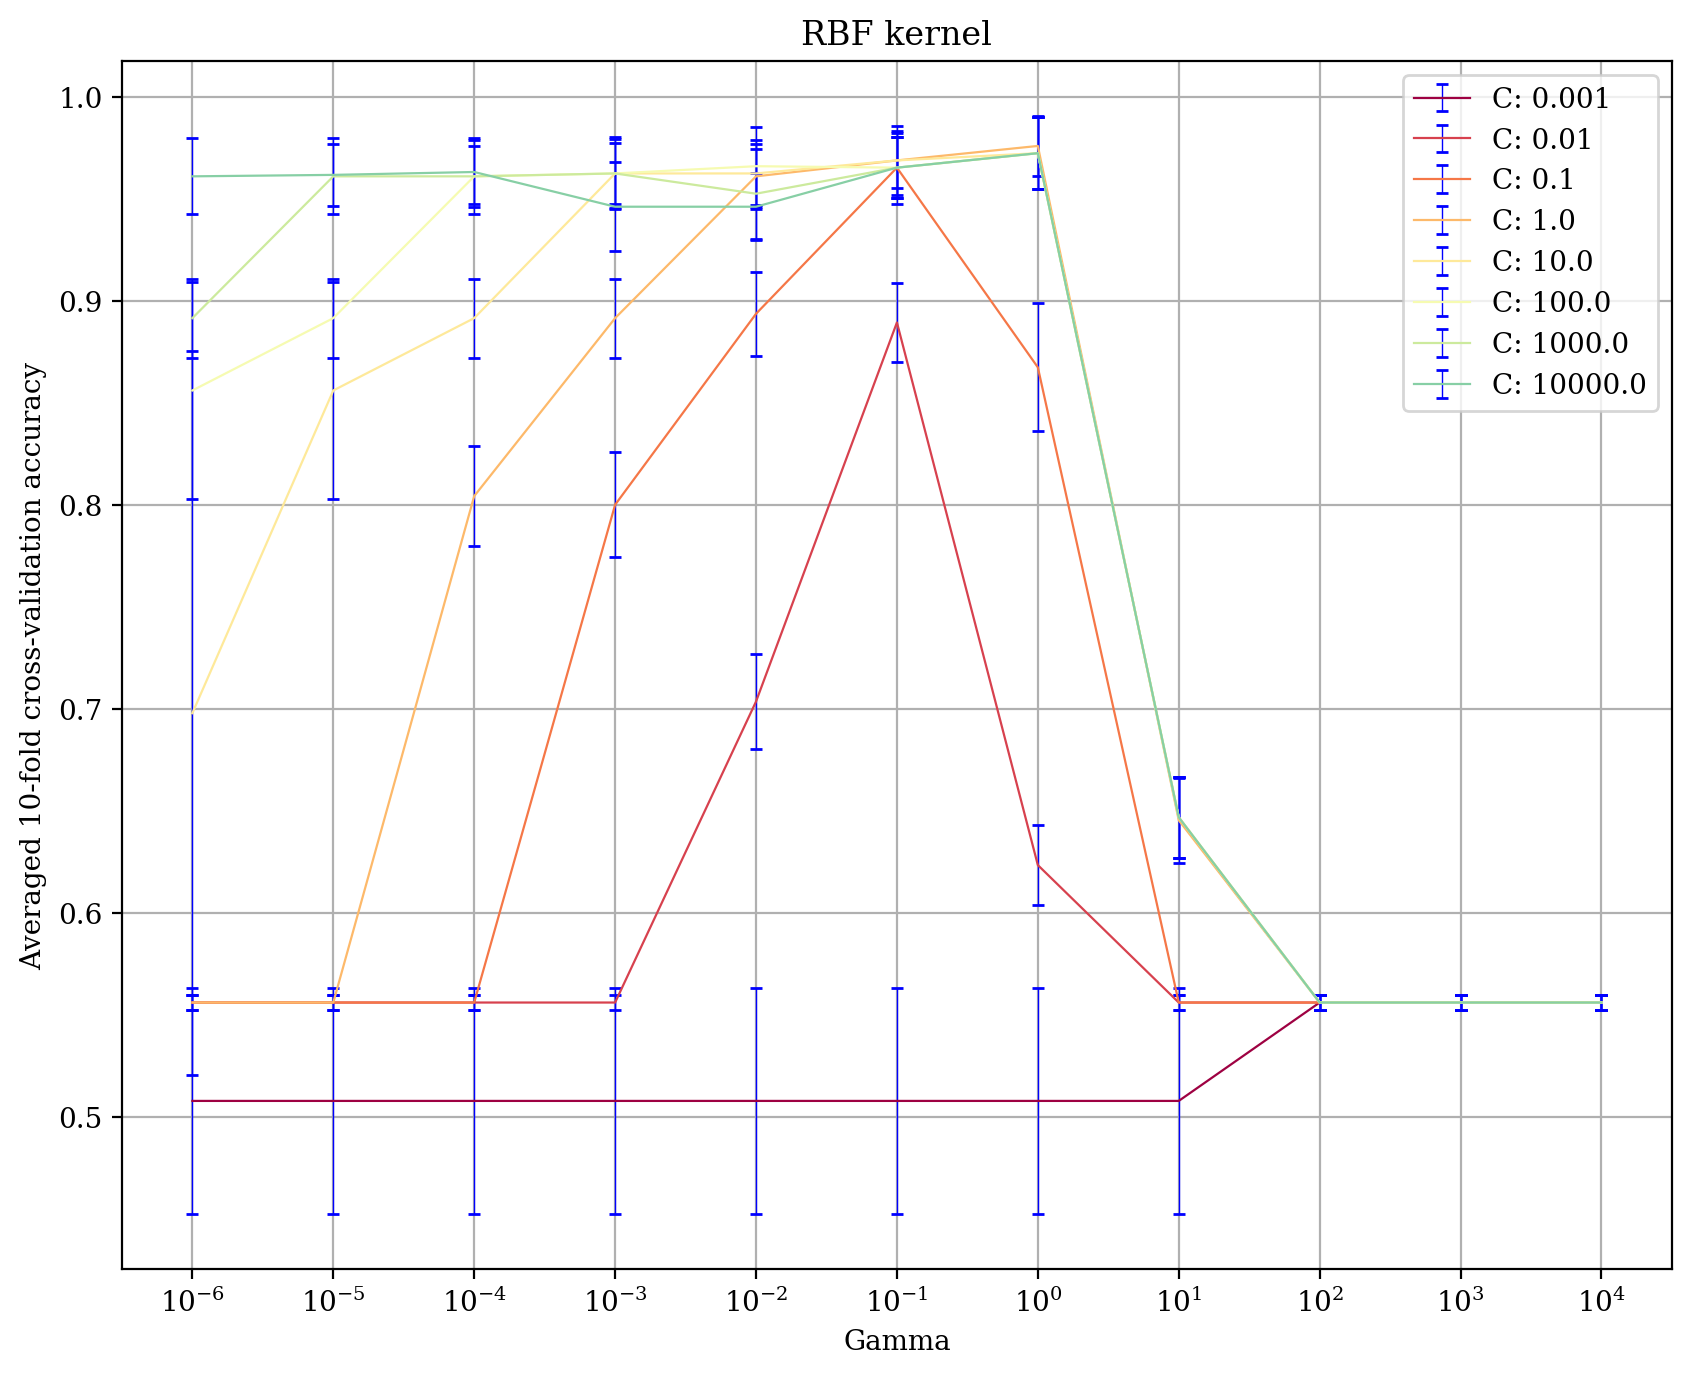

The optimum hyperparameters found by the Gridsearch are:
{'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
The best estimator gets an score of:  0.975886524822695
Figure not saved.


In [47]:
plot_gridsearch_results(lin_set1)
plot_gridsearch_results(lin_set2)
plot_gridsearch_results(rbf_set1)
plot_gridsearch_results(rbf_set2)

## Noise testing:

#### PCA noise:

In [33]:
model_lin = SVC(C=0.1,kernel='linear',probability=False,decision_function_shape='ovr',class_weight='balanced')

Number of pca components used to calculate the noise  292  of a total of  300  pca components.


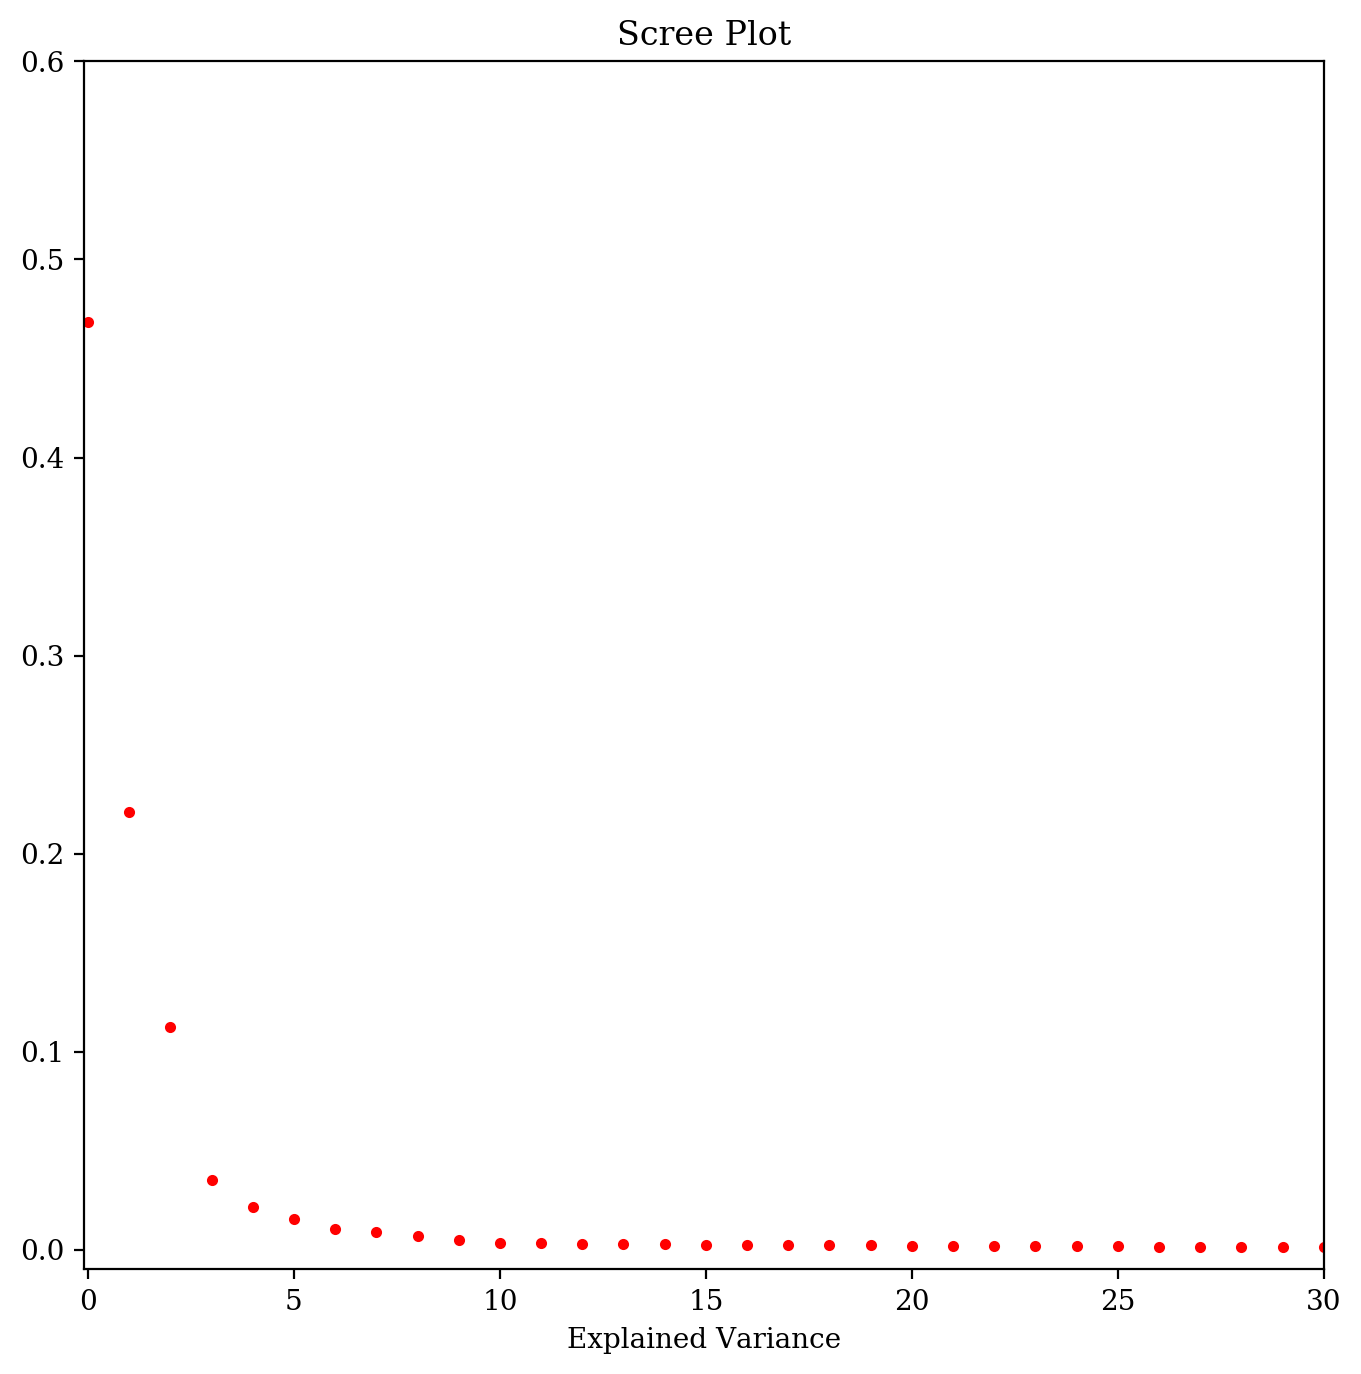

In [34]:
noise_spectra, acc_pca = noise_PCA_spectra(model_lin, MF_rw_c, labels_MFrw, 5, True)

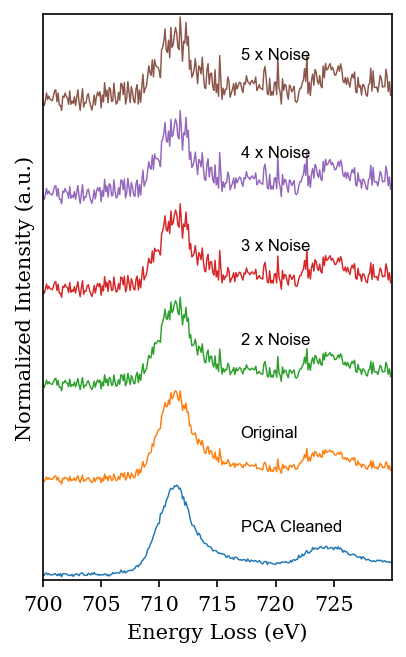

Figure not saved.


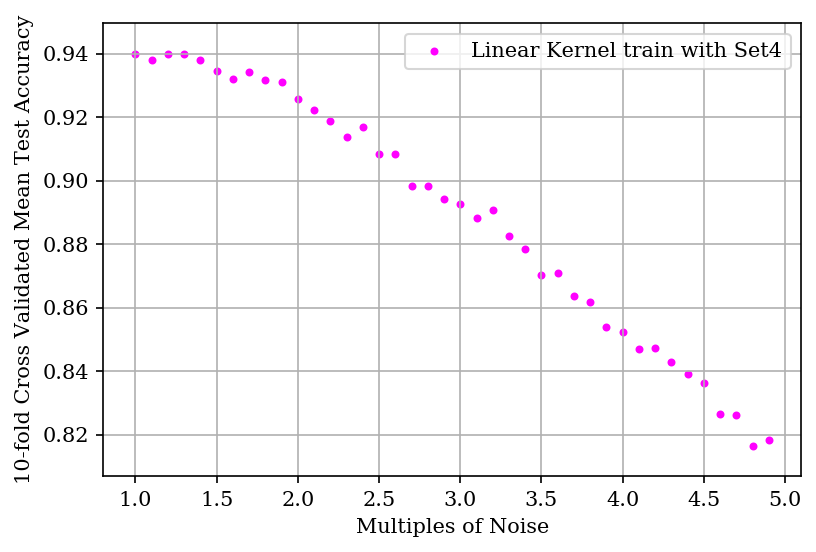

Figure not saved.


In [35]:
plot_PCA_noise(noise_spectra,5,Fe_All_c,ax=700.,bx=730.,random_spectra=1400)
plot_PCA_acc(acc_pca,'Linear Kernel train with Set4')

#### Gaussian noise, Possonian noise and their combination:

In [36]:
shot_spec,gaus_spec,both_spec = add_gaus_shot_noise(Fe_All_c,True,0.15,True)

Gaussian and Poisonian Noise added.


In [39]:
model_rbf = SVC(C=10.,kernel='rbf',gamma=0.1,probability=False,decision_function_shape='ovr',class_weight='balanced')
accuracy = test_svm_cv(model_rbf,MF_rw_c,labels_MFrw,cv=10)

Averaged  10 -fold cross-validation accuracy: 0.96 (+/- 0.06)


Random spectra selected with index:  309


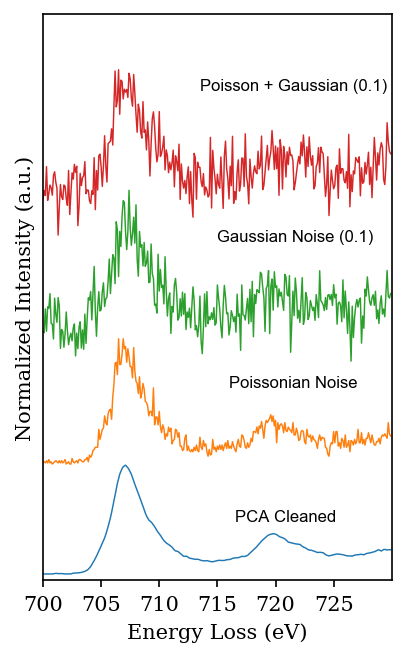

Figure not saved.


In [40]:
plot_gaus_pois_noise(Fe_All_c,shot_spec,gaus_spec,both_spec,700.,730.)

In [41]:
model_linear = SVC(C=100.,kernel='linear',probability=False,decision_function_shape='ovr',class_weight='balanced')

acc_shot = cross_fold_validation(model_linear,Fe_All_c,labels,shot_spec,labels,0.65,shift=False,cv=10)
acc_gaus = cross_fold_validation(model_linear,Fe_All_c,labels,gaus_spec,labels,0.65,shift=False,cv=10)
acc_both = cross_fold_validation(model_linear,Fe_All_c,labels,both_spec,labels,0.65,shift=False,cv=10)
print('Shot noise accuracy:',acc_shot)
print('Gaussian noise accuracy:',acc_shot)
print('Both noise accuracy:',acc_shot)

Shot noise accuracy: 0.953421052631579
Gaussian noise accuracy: 0.953421052631579
Both noise accuracy: 0.953421052631579


## Test chemical shifts:

In [42]:
acc_shift = []
model_wf = SVC(C=100,kernel='linear',probability=False,decision_function_shape='ovr',class_weight='balanced')
num_bins_translate = 80
x_val = MF_rw_c
y_val = labels_MF
x_test = MF_rw
y_test = labels_MF

print(MF_rw_c.shape,MF_rw.shape)

train_size = .8
acc_shift.append(chemical_shifts(model_wf,x_val,y_val,x_test,y_test,num_bins_translate,train_size,10))
train_size = .6
acc_shift.append(chemical_shifts(model_wf,x_val,y_val,x_test,y_test,num_bins_translate,train_size,10))
train_size = .5
acc_shift.append(chemical_shifts(model_wf,x_val,y_val,x_test,y_test,num_bins_translate,train_size,10))
train_size = .4
acc_shift.append(chemical_shifts(model_wf,x_val,y_val,x_test,y_test,num_bins_translate,train_size,10))
train_size = .2
acc_shift.append(chemical_shifts(model_wf,x_val,y_val,x_test,y_test,num_bins_translate,train_size,10))
train_size = .1
acc_shift.append(chemical_shifts(model_wf,x_val,y_val,x_test,y_test,num_bins_translate,train_size,10))

(5328, 300) (5328, 400)


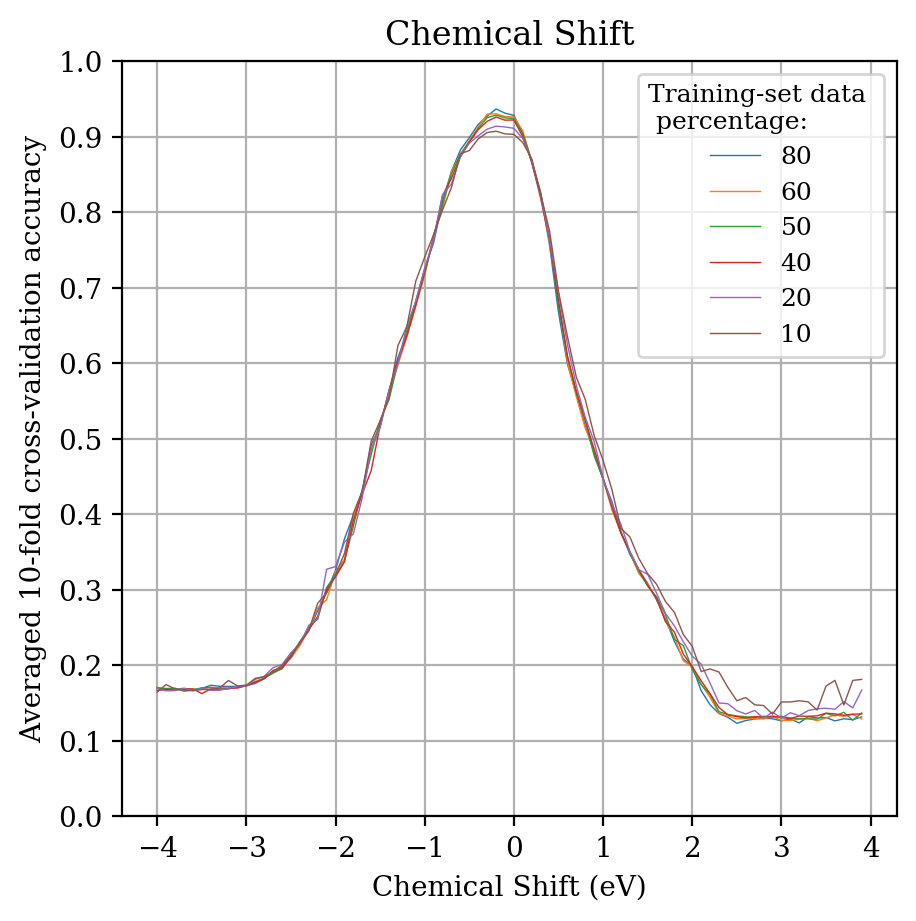

Figure not saved.


In [43]:
plot_chemical_shift(np.arange(-4,4,step=0.1),acc_shift,['80','60','50','40','20','10'],'Chemical Shift')

## Confusion matrices:

In [ ]:
os.chdir(r"Gridsearch_results")

In [35]:
#Load the best and worst model: 
lin_set3 = joblib.load('lin_set3_ovr') #worst model = model 7 
rbf_set4 = joblib.load('rbf_set4_ovr') #best model = model 12

In [38]:
a,x_test,b,y_test = train_test_split(MF_c,labels_MF,test_size=.35)

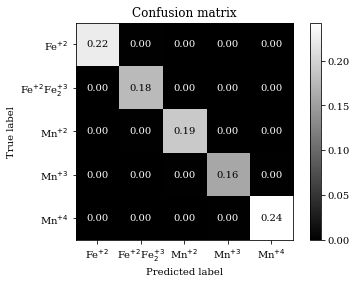

In [39]:
plot_conf_matrix(lin_set3.best_estimator_, x_test, y_test,['Fe$^{+2}$','Fe$^{+2}$Fe$^{+3}_2$','Mn$^{+2}$','Mn$^{+3}$','Mn$^{+4}$'])

In [40]:
a,x_test,b,y_test = train_test_split(MF_rw_c,labels_MF,test_size=.35)

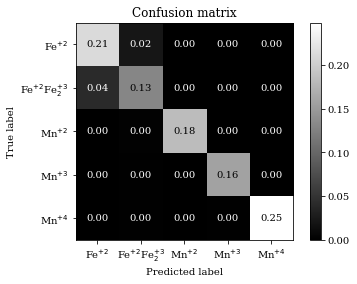

In [41]:
plot_conf_matrix(rbf_set4.best_estimator_, x_test, y_test,['Fe$^{+2}$','Fe$^{+2}$Fe$^{+3}_2$','Mn$^{+2}$','Mn$^{+3}$','Mn$^{+4}$'])